#### Prepare Dataset
- Install Packages
- Import Packages
- Download Data

##### Install Packages

In [1]:
# pip install copernicus_marine_client

In [2]:
# pip install keras-tuner --upgrade

##### Import Packages

In [3]:
import os
import xarray as xr
import copernicus_marine_client as copernicusmarine

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
import keras_tuner

2023-12-22 21:13:48.236537: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-22 21:13:48.275058: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
random_seed = 5
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed) #try to get same result every time...

##### Download Data  
- Download data from source website form two dataset_id
- Merge two dataset

In [5]:
# Download data from source website form two dataset_id
copernicusmarine.login("xfeng4","Sf1260358662@") #login, overwrite it ? [y/N]: y

#field name in dataset
data_variables = ["sithick","siconc","thetao","bottomT","so", "usi", "vsi","uo","vo"]

#create folder to store raw data
cwd = os.getcwd()
folder = "sea ice thickness dataset"

site = {
"greenland": (-58.133, -57.718, 82.892, 83.307),
"bering_strait": (-174.477, -172.402, 76.268, 78.343)} #create dictionary: {site: min_long, max_long, min_lat, max_long}

active_site = "bering_strait" #current running site
folder_path = os.path.join(cwd, folder, active_site) 
os.makedirs(folder_path, exist_ok=True) 

File /home/jovyan/.copernicus-marine-client/.copernicus-marine-credentials already exists, overwrite it ? [y/N]:

  y


INFO - 2023-12-22T21:14:33Z - Credentials file stored in /home/jovyan/.copernicus-marine-client/.copernicus-marine-credentials.


In [6]:
#first dataset
for var in data_variables:
    output_file = os.path.join(folder_path, f"{var}_id1.nc")
    if os.path.exists(output_file):
        pass
    else:
        copernicusmarine.subset(
          dataset_id="cmems_mod_glo_phy_my_0.083deg_P1D-m",
          variables=[var],
          minimum_longitude=site[active_site][0],
          maximum_longitude=site[active_site][1],
          minimum_latitude=site[active_site][2],
          maximum_latitude=site[active_site][3],
          start_datetime="1993-01-01T00:00:00",
          end_datetime="2021-06-30T23:59:59",
          output_filename=output_file)

#second dataset ID
for var in data_variables:
    output_file = os.path.join(folder_path, f"{var}_id2.nc")
    if os.path.exists(output_file):
        pass
    else:
        copernicusmarine.subset(
          dataset_id="cmems_mod_glo_phy_myint_0.083deg_P1D-m",
          variables=[var],
          minimum_longitude=site[active_site][0],
          maximum_longitude=site[active_site][1],
          minimum_latitude=site[active_site][2],
          maximum_latitude=site[active_site][3],
          start_datetime="2021-07-01T00:00:00",
          end_datetime="2023-07-31T23:59:59",
          output_filename=os.path.join(folder_path, f"{var}_id2.nc"))
        
print("down")

down


In [7]:
#Merge two dataset
os.makedirs(os.path.join(folder_path, "Merged"), exist_ok=True) 

for var in data_variables:
    output_file = os.path.join(folder_path, "Merged", f"{var}_merged.nc")
    if os.path.exists(output_file):
        pass
    else:
        data_id1_file = os.path.join(folder_path, f"{var}_id1.nc")
        data_id2_file = os.path.join(folder_path, f"{var}_id2.nc")
        data_id1_xr = xr.open_dataset(data_id1_file)
        data_id2_xr = xr.open_dataset(data_id2_file)
        data_xr = xr.merge([data_id1_xr, data_id2_xr])
        data_file = os.path.join(folder_path, "Merged", f"{var}_merged.nc")
        data_xr.to_netcdf(data_file)
        
print("down")

down


#### Process Data
- read as xarray, drop "depth" dimension, and merge xrray
- normalization
- flat data for NN
- time slider for LSTM

##### Read as xarray, drop "depth" dimension, and merge xarray

In [8]:
#extract training_data
#create variable for time slice
training_time_range = slice('1993-01-01', '2018-12-31')
testing_time_range = slice('2019-01-01', '2023-07-31')

input_features = ["siconc","thetao","bottomT","so", "usi", "vsi","uo","vo"]
output_features = ["sithick"]

training_data = {}
for var in data_variables:
    data_file = os.path.join(folder_path, "Merged", f"{var}_merged.nc")
    selection_dataset = xr.open_dataset(data_file)
    selection_dataset_time = selection_dataset.sel(time=training_time_range)

    if 'depth' in selection_dataset_time[var].dims: #drop "depth" if it exists
        selection_dataset_time[var] = selection_dataset_time[var].mean(dim='depth')
        selection_dataset_time = selection_dataset_time.drop_vars("depth")
        check_nans = selection_dataset_time[var].isnull().any()
        if check_nans: #complete data via linear interpolate
            selection_dataset_time[var] = selection_dataset_time[var].interpolate_na(dim='time')
    else:
        check_nans = selection_dataset_time[var].isnull().any()
        if check_nans:
            selection_dataset_time[var] = selection_dataset_time[var].interpolate_na(dim='time')

    training_data[var] = selection_dataset_time

#check if dimensions same: only keep time, lat and lon
dimensions = None
for var, dataset in training_data.items():
    if dimensions is None:
        dimensions = dataset.dims
    elif dimensions != dataset.dims:
        raise ValueError(f"Dimension mismatch in variable {var}")

train = xr.merge([training_data[var] for var in data_variables])

#get input and output variables 
x_train_xr = train[input_features]
y_train_xr = train[output_features]

In [9]:
#extract testing_data
#write a function for extract and merge
testing_data = {}
for var in data_variables:
    data_file = os.path.join(folder_path, "Merged", f"{var}_merged.nc")
    selection_dataset = xr.open_dataset(data_file)
    selection_dataset_time = selection_dataset.sel(time=testing_time_range)

    if 'depth' in selection_dataset_time[var].dims:
        selection_dataset_time[var] = selection_dataset_time[var].mean(dim='depth')
        selection_dataset_time = selection_dataset_time.drop_vars("depth")
        check_nans = selection_dataset_time[var].isnull().any()
        if check_nans:
            selection_dataset_time[var] = selection_dataset_time[var].interpolate_na(dim='time')
    else:
        check_nans = selection_dataset_time[var].isnull().any()
        if check_nans:
            selection_dataset_time[var] = selection_dataset_time[var].interpolate_na(dim='time')

    testing_data[var] = selection_dataset_time
    
dimensions = None
for var, dataset in testing_data.items():
    if dimensions is None:
        dimensions = dataset.dims
    elif dimensions != dataset.dims:
        raise ValueError(f"Dimension mismatch in variable {var}")

test = xr.merge([testing_data[var] for var in data_variables])

x_test_xr = test[input_features]
y_test_xr = test[output_features]

##### Normalization

In [10]:
meanstd_inputs = {}
predictors = input_features

def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    return (data - mean)/std

for var in predictors:
    meanstd_inputs[var] = (x_train_xr[var].data.mean(), x_train_xr[var].data.std())
    
# normalize each variables
for var in predictors:
    # training set
    var_dims   = x_train_xr[var].dims
    x_train_xr = x_train_xr.assign({var: (var_dims, normalize(x_train_xr[var].data, var, meanstd_inputs))})
    
    # test set
    var_dims  = x_test_xr[var].dims
    x_test_xr = x_test_xr.assign({var: (var_dims, normalize(x_test_xr[var].data, var, meanstd_inputs))})

In [11]:
x_train_np  = x_train_xr.to_array().transpose('time', 'latitude', 'longitude', 'variable').data
x_test_np  = x_test_xr.to_array().transpose('time', 'latitude', 'longitude', 'variable').data

y_train_np = y_train_xr[output_features[0]].data
y_test_np = y_test_xr[output_features[0]].data

print(x_train_np.shape, x_test_np.shape, y_train_np.shape, y_test_np.shape)

(9496, 25, 25, 8) (1673, 25, 25, 8) (9496, 25, 25) (1673, 25, 25)


In [12]:
#check n_lat and n_long and extract shape value
if x_train_np.shape[1:3] == x_test_np.shape[1:3] == y_train_np.shape[1:3] == y_test_np.shape[1:3]:
    n_lat, n_lon = x_train_np.shape[1:3]

print(n_lat, n_lon)

25 25


##### Flat data for NN

In [13]:
#convert model to 1D for NN
x_train_flattened = x_train_np.reshape(x_train_np.shape[0], -1)  # x_train.shape[0] is the number of samples
y_train_flattened = y_train_np.reshape(y_train_np.shape[0], -1)
x_test_flattened = x_test_np.reshape(x_test_np.shape[0], -1)

##### Add time slider for LSTM

In [14]:
#adjust dataset to feed LSTM
slider = 5
x_train_slider = np.array([x_train_np[i:i+slider] for i in range(0, x_train_np.shape[0]-slider+1)])
y_train_slider = np.array([y_train_np[i+slider-1] for i in range(0, y_train_np.shape[0]-slider+1)])
y_train_slider = y_train_slider.reshape(y_train_slider.shape[0], 1, y_train_slider.shape[1], y_train_slider.shape[2])

x_test_slider = np.array([x_test_np[i:i+slider] for i in range(0, x_test_np.shape[0]-slider+1)])

print(x_train_np.shape, x_train_slider.shape)
print(y_train_np.shape, y_train_slider.shape)
print(x_test_np.shape, x_test_slider.shape)

#stack them to get shape (n_timepoints, n_slider, features)
input_shape = (slider, n_lat, n_lon, (len(data_variables)-1))  # time slider, lat, long, features
output_shape = (1, n_lat, n_lon)    # lat, long

# Flatten the spatial dimensions for the LSTM input
flattened_spatial_dim = input_shape[1] * input_shape[2] * input_shape[3]

(9496, 25, 25, 8) (9492, 5, 25, 25, 8)
(9496, 25, 25) (9492, 1, 25, 25)
(1673, 25, 25, 8) (1669, 5, 25, 25, 8)


#### Train the model
- NN
- CNN + keras_tuner
- LSTM + keras_tuner
- CNN LSTM + keras_tuner  
*how to do feature selection?*

##### NN

In [15]:
#set parameters
method = "NN"

n_neuron       = 256 #the number of n_neuron
activation     = 'relu' #activation methods
num_epochs     = 50 #go through how many times weight adjusted
learning_rate  = 0.001 #related to optimize
minibatch_size = 64 #the batch to calculate delta to optimize
N_layers       = 3 #number of hidden layers

In [16]:
# loss = "mse"
model_mse = Sequential()
model_mse.add(Dense(n_neuron,  activation=activation, name="hidden_layer_1" ,input_shape=(x_train_flattened.shape[1],)))
for n in range(N_layers-1):
    model_mse.add(Dense(n_neuron,  activation=activation, name="hidden_layer_"+str(n+2))) 
model_mse.add(Dense(y_train_flattened.shape[1],  activation="linear", name="output_layer")) # the output layer
model_mse.compile(loss="mse",optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

model_mse.summary()

# lose = "mae"
model_mae = Sequential()
model_mae.add(Dense(n_neuron,  activation=activation, name="hidden_layer_1" ,input_shape=(x_train_flattened.shape[1],)))
for n in range(N_layers-1):
    model_mae.add(Dense(n_neuron,  activation=activation, name="hidden_layer_"+str(n+2))) 
model_mae.add(Dense(y_train_flattened.shape[1],  activation="linear", name="output_layer")) # the output layer
model_mae.compile(loss='mae',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

model_mae.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 256)               1280256   
                                                                 
 hidden_layer_2 (Dense)      (None, 256)               65792     
                                                                 
 hidden_layer_3 (Dense)      (None, 256)               65792     
                                                                 
 output_layer (Dense)        (None, 625)               160625    
                                                                 
Total params: 1,572,465
Trainable params: 1,572,465
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense) 

In [17]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15) #adjust patience

# model_mse
history_mse = model_mse.fit(x_train_flattened, y_train_flattened, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])
# model_mae
history_mae = model_mae.fit(x_train_flattened, y_train_flattened, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/50
119/119 [==============================] - 2s 16ms/step - loss: 0.5222 - val_loss: 2.2474
Epoch 2/50
119/119 [==============================] - 2s 14ms/step - loss: 0.0805 - val_loss: 1.8742
Epoch 3/50
119/119 [==============================] - 2s 14ms/step - loss: 0.0594 - val_loss: 1.7273
Epoch 4/50
119/119 [==============================] - 2s 15ms/step - loss: 0.0457 - val_loss: 1.7865
Epoch 5/50
119/119 [==============================] - 2s 14ms/step - loss: 0.0380 - val_loss: 1.5372
Epoch 6/50
119/119 [==============================] - 2s 14ms/step - loss: 0.0327 - val_loss: 1.4200
Epoch 7/50
119/119 [==============================] - 2s 15ms/step - loss: 0.0300 - val_loss: 1.5306
Epoch 8/50
119/119 [==============================] - 2s 14ms/step - loss: 0.0235 - val_loss: 1.3644
Epoch 9/50
119/119 [==============================] - 2s 14ms/step - loss: 0.0261 - val_loss: 1.3344
Epoch 10/50
119/119 [==============================] - 2s 15ms/step - loss: 0.0256 - val_lo

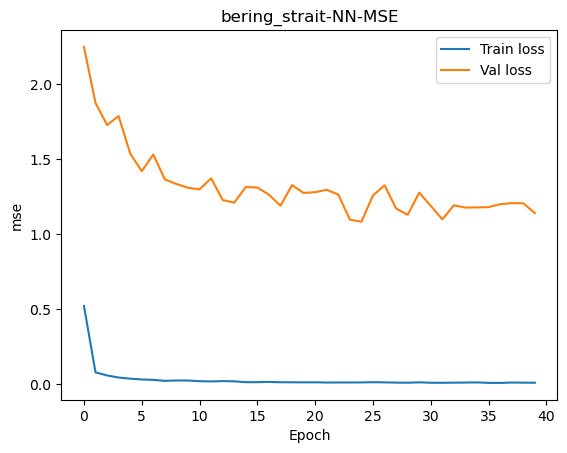

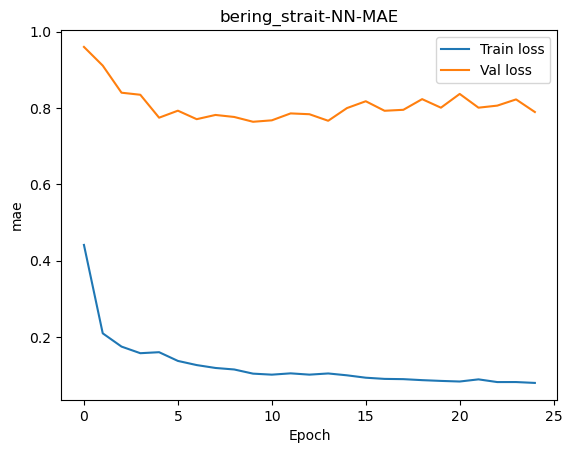

In [18]:
#plot loss value
# loss = "mse"
plt.plot(history_mse.history['loss'])
plt.plot(history_mse.history['val_loss'])
plt.title(f'{active_site}-{method}-MSE', fontsize=12)
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')
plt.show()

# loss = "mae"
plt.plot(history_mae.history['loss'])
plt.plot(history_mae.history['val_loss'])
plt.title(f'{active_site}-{method}-MAE', fontsize=12)
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')
plt.show()

In [19]:
model_path = os.path.join(cwd,'saved_model', active_site)
os.makedirs(model_path, exist_ok=True)
model_mse.save(os.path.join(model_path,'NN_mse_model.h5'))
model_mae.save(os.path.join(model_path, 'NN_mae_model.h5'))

##### CNN + Keras tuner

In [20]:
# set parameters
method = "CNN"

minibatch_size = 64
num_epochs     = 50
n_trials       = 12   # total number of trials in hyperparameter tuning

In [21]:
def CNN_model(hp):
    
    # options for hyperparameters
    hp_filters = hp.Choice('filters', values=[16,32,64])
    hp_kernel_size = hp.Choice('kernel_size', values=[2,3,4,5])
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_loss = hp.Choice('loss', values=['mse','mae'])
    
    # build CNN models according to the hyperparameters
    model = keras.models.Sequential()

    model.add(Dense(hp_filters, input_shape=x_train_np.shape[1:], activation=hp_activation)) 
    
    model.add(Conv2DTranspose(filters=hp_filters, kernel_size=hp_kernel_size, 
                              activation=hp_activation, strides=1, padding='same')) # shape: (n_lat, n_lon, filters)
    
    model.add(Conv2DTranspose(filters=hp_filters, kernel_size=hp_kernel_size, 
                              activation=hp_activation, strides=1, padding='same')) #strids =1 plus padding ="same", stay same shape
    
    model.add(Conv2DTranspose(filters=hp_filters, kernel_size=hp_kernel_size, 
                              activation=hp_activation, strides=1, padding='same'))
    
    model.add(Conv2DTranspose(filters=1, kernel_size=hp_kernel_size, 
                              activation="linear", padding="same")) 
    
    model.compile(loss=hp_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate))
    
    return model

In [22]:
random_tuner = keras_tuner.RandomSearch(CNN_model, 
                                        max_trials=n_trials,
                                        seed=5,
                                        objective='val_loss', 
                                        max_retries_per_trial=0,
                                        max_consecutive_failed_trials=3,
                                        directory='random_search', 
                                        project_name=f'{active_site}_random_search_CNN_12trials')

Reloading Tuner from random_search/bering_strait_random_search_CNN_12trials/tuner0.json


In [23]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

random_tuner.search(x_train_np, y_train_np,
                    batch_size = minibatch_size,
                    epochs = num_epochs, 
                    validation_split = 0.2, 
                    callbacks = [early_stop])


In [24]:
best_model = random_tuner.get_best_models()[0]
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25, 25, 32)        288       
                                                                 
 conv2d_transpose (Conv2DTra  (None, 25, 25, 32)       4128      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 25, 25, 32)       4128      
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 25, 25, 32)       4128      
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 25, 25, 1)        129       
 ranspose)                                              

In [25]:
# best hyperparameters
best_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[0]
print(best_hps.values)
# top2 hyperparameters
top2_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[1]

{'filters': 32, 'kernel_size': 2, 'activation': 'sigmoid', 'learning_rate': 0.0001, 'loss': 'mae'}


In [26]:
# model_best
model_best = random_tuner.hypermodel.build(best_hps)
history_best = model_best.fit(x_train_np, y_train_np,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])

# model top2
model_top2 = random_tuner.hypermodel.build(top2_hps)
history_top2 = model_top2.fit(x_train_np, y_train_np,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])

Epoch 1/50
119/119 [==============================] - 9s 70ms/step - loss: 1.0767 - val_loss: 0.9542
Epoch 2/50
119/119 [==============================] - 8s 66ms/step - loss: 0.7323 - val_loss: 1.0258
Epoch 3/50
119/119 [==============================] - 8s 69ms/step - loss: 0.7252 - val_loss: 0.9968
Epoch 4/50
119/119 [==============================] - 8s 65ms/step - loss: 0.7168 - val_loss: 1.0120
Epoch 5/50
119/119 [==============================] - 8s 65ms/step - loss: 0.7062 - val_loss: 0.9889
Epoch 6/50
119/119 [==============================] - 8s 65ms/step - loss: 0.6920 - val_loss: 0.9717
Epoch 7/50
119/119 [==============================] - 8s 66ms/step - loss: 0.6696 - val_loss: 0.9480
Epoch 8/50
119/119 [==============================] - 8s 65ms/step - loss: 0.6295 - val_loss: 0.8862
Epoch 9/50
119/119 [==============================] - 8s 66ms/step - loss: 0.5707 - val_loss: 0.7823
Epoch 10/50
119/119 [==============================] - 8s 66ms/step - loss: 0.5318 - val_lo

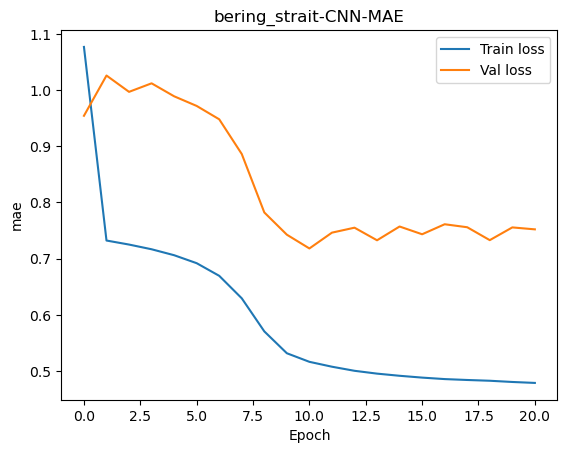

In [27]:
# set up title and ylabel strings

title_best = f"{active_site}-{method}-" + str(best_hps['loss']).upper()
ylabel_best = best_hps['loss']

title_top2 = f"{active_site}-{method}-" + str(best_hps['loss']).upper()
ylabel_top2 = top2_hps['loss']


# plot loss
#best
plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title(title_best, fontsize=12)
plt.ylabel(ylabel_best)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')
plt.show()

# #top2
# plt.plot(history_top2.history['loss'])
# plt.plot(history_top2.history['val_loss'])
# plt.title(title_top2, fontsize=12)
# plt.ylabel(ylabel_top2)
# plt.xlabel('Epoch')
# plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')
# plt.show()

In [28]:
model_path = os.path.join(cwd,'saved_model', active_site)
os.makedirs(model_path, exist_ok=True)

model_best.save(os.path.join(model_path,'CNN_model_randomsearch_10trials_rank1.h5'))
model_top2.save(os.path.join(model_path,'CNN_model_randomsearch_10trials_rank2.h5'))

##### LSTM + keras tuner

In [29]:
# set hyperparameters
method = "LSTM"

num_epochs     = 50
minibatch_size = 64
n_trials = 12

In [30]:
def LSTM_model(hp):

    hp_neuron = hp.Choice('filters', values=[32, 64, 128])
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_loss = hp.Choice('loss', values=['mse','mae'])
    model = Sequential()
    model.add(Reshape((input_shape[0], flattened_spatial_dim), input_shape=input_shape))
    model.add(LSTM(hp_neuron, return_sequences=True, activation=hp_activation)) #if hp_neuron goes to large, return error, why?
    model.add(LSTM(hp_neuron, return_sequences=False, activation=hp_activation))
    model.add(Dense(output_shape[1] * output_shape[2], activation="linear"))
    model.add(Reshape(output_shape))

    model.compile(loss=hp_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate))
    return model


In [31]:
random_tuner = keras_tuner.RandomSearch(LSTM_model, 
                                        max_trials=n_trials,
                                        seed=5,
                                        objective='val_loss', 
                                        max_retries_per_trial=0,
                                        max_consecutive_failed_trials=3,
                                        directory='random_search', 
                                        project_name=f'{active_site}_random_search_LSTM_12trials')

Reloading Tuner from random_search/bering_strait_random_search_LSTM_12trials/tuner0.json


In [32]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

random_tuner.search(x_train_slider, y_train_slider,
                    batch_size = minibatch_size,
                    epochs = num_epochs, 
                    validation_split = 0.2, 
                    callbacks = [early_stop])

In [33]:
best_model = random_tuner.get_best_models()[0]
best_model.summary()

2023-12-22 21:27:53.031962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-22 21:27:53.033240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-22 21:27:53.034093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 5, 5000)           0         
                                                                 
 lstm (LSTM)                 (None, 5, 64)             1296640   
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 625)               40625     
                                                                 
 reshape_1 (Reshape)         (None, 1, 25, 25)         0         
                                                                 
Total params: 1,370,289
Trainable params: 1,370,289
Non-trainable params: 0
_________________________________________________________________


In [34]:
best_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[0]
top2_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[1]
print(best_hps.values)

{'filters': 64, 'activation': 'tanh', 'learning_rate': 0.0001, 'loss': 'mse'}


In [35]:
#Best
model_best = random_tuner.hypermodel.build(best_hps)

history_best = model_best.fit(x_train_slider, y_train_slider,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])

#Top2
model_top2 = random_tuner.hypermodel.build(top2_hps)

history_top2 = model_top2.fit(x_train_slider, y_train_slider,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])


2023-12-22 21:27:55.545233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-22 21:27:55.546392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-22 21:27:55.547392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-12-22 21:27:56.274895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-22 21:27:56.276291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-22 21:27:56.277224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

119/119 [==============================] - ETA: 0s - loss: 5.2409

2023-12-22 21:28:02.794808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-22 21:28:02.796277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-22 21:28:02.797202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

119/119 [==============================] - 7s 43ms/step - loss: 5.2409 - val_loss: 1.1539
Epoch 2/50
119/119 [==============================] - 5s 38ms/step - loss: 2.0768 - val_loss: 0.4867
Epoch 3/50
119/119 [==============================] - 5s 38ms/step - loss: 0.8411 - val_loss: 0.6211
Epoch 4/50
119/119 [==============================] - 5s 38ms/step - loss: 0.3892 - val_loss: 0.8490
Epoch 5/50
119/119 [==============================] - 5s 38ms/step - loss: 0.2184 - val_loss: 0.9788
Epoch 6/50
119/119 [==============================] - 5s 38ms/step - loss: 0.1459 - val_loss: 1.0345
Epoch 7/50
119/119 [==============================] - 5s 38ms/step - loss: 0.1093 - val_loss: 1.0540
Epoch 8/50
119/119 [==============================] - 5s 38ms/step - loss: 0.0845 - val_loss: 1.0345
Epoch 9/50
119/119 [==============================] - 5s 38ms/step - loss: 0.0662 - val_loss: 0.9614
Epoch 10/50
119/119 [==============================] - 5s 38ms/step - loss: 0.0551 - val_loss: 0.9542


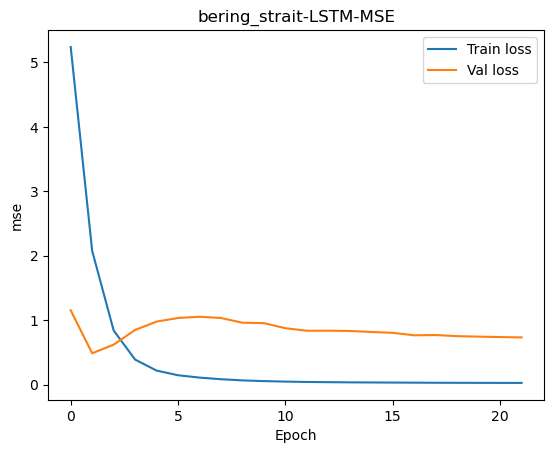

In [36]:
# set up title and ylabel strings
title_best = f"{active_site}-{method}-" + str(best_hps['loss']).upper()
ylabel_best = best_hps['loss']

title_top2 = f"{active_site}-{method}-" + str(best_hps['loss']).upper()
ylabel_top2 = top2_hps['loss']


# plot loss
#best
plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title(title_best, fontsize=12)
plt.ylabel(ylabel_best)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')
plt.show()

# #top2
# plt.plot(history_top2.history['loss'])
# plt.plot(history_top2.history['val_loss'])
# plt.title(title_top2, fontsize=12)
# plt.ylabel(ylabel_top2)
# plt.xlabel('Epoch')
# plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')
# plt.show()

In [37]:
model_path = os.path.join(cwd,'saved_model', active_site)
model_best.save(os.path.join(model_path,'LSTM_model_randomsearch_12trials_rank1.h5'))
model_top2.save(os.path.join(model_path,'LSTM_model_randomsearch_12trials_rank2.h5'))

##### CNN_LSTM + keras tuner

In [38]:
#set random search parameters
method = "CNN_LSTM"

n_trials = 10
minibatch_size = 64
num_epochs = 50
pool_size=2

In [39]:
### model using mse as loss function
def CNN_LSTM_model(hp):

    hp_filters = hp.Choice('filters', values=[32, 64, 128])
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    hp_loss = hp.Choice('loss', values=['mse','mae'])
    hp_kernel = hp.Choice("kernel_size", values=[3, 4, 5])
    hp_lstm_unit = hp.Choice("lstm_unit", values=[25, 50])
    
    model = Sequential()

    model.add(Input(shape=(slider, n_lat,n_lon, (len(data_variables)-1))))
    model.add(TimeDistributed(Conv2D(hp_filters, (hp_kernel, hp_kernel), 
                                         padding='same', activation=hp_activation), 
                                         input_shape=(slider, n_lat,n_lon,(len(data_variables)-1))))
    model.add(TimeDistributed(AveragePooling2D(pool_size)))
    model.add(TimeDistributed(GlobalAveragePooling2D()))
    model.add(LSTM(hp_lstm_unit, activation=hp_activation))
    model.add(Dense(n_lat*n_lon))
    model.add(Activation('linear'))
    model.add(Reshape((1, n_lat, n_lon)))
    model.compile(loss=hp_loss,optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate))

    return model

In [40]:
random_tuner = keras_tuner.RandomSearch(CNN_LSTM_model, 
                                        max_trials=n_trials,
                                        seed=5,
                                        objective='val_loss', 
                                        max_retries_per_trial=0,
                                        max_consecutive_failed_trials=3,
                                        directory='random_search', 
                                        project_name=f'{active_site}_random_search_CNN_LSTM_10trials')

Reloading Tuner from random_search/bering_strait_random_search_CNN_LSTM_10trials/tuner0.json


In [41]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
random_tuner.search(x_train_slider, y_train_slider,
                    batch_size = minibatch_size,
                    epochs = num_epochs, 
                    validation_split = 0.2, 
                    callbacks = [early_stop])

In [42]:
best_model = random_tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 5, 25, 25, 64)    4672      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 12, 12, 64)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 5, 64)            0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                23000     
                                                                 
 dense (Dense)               (None, 625)               31875     
                                                        

In [43]:
best_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[0]
top2_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[1]
print(best_hps.values)

{'filters': 64, 'activation': 'sigmoid', 'learning_rate': 0.001, 'loss': 'mae', 'kernel_size': 3, 'lstm_unit': 50}


In [44]:
#Best
model_best = random_tuner.hypermodel.build(best_hps)

history_best = model_best.fit(x_train_slider, y_train_slider,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])

#Top2
model_top2 = random_tuner.hypermodel.build(top2_hps)

history_top2 = model_top2.fit(x_train_slider, y_train_slider,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])


Epoch 1/50
119/119 [==============================] - 15s 118ms/step - loss: 0.9766 - val_loss: 0.7308
Epoch 2/50
119/119 [==============================] - 14s 119ms/step - loss: 0.4360 - val_loss: 0.7614
Epoch 3/50
119/119 [==============================] - 14s 120ms/step - loss: 0.4193 - val_loss: 0.7919
Epoch 4/50
119/119 [==============================] - 14s 117ms/step - loss: 0.4157 - val_loss: 0.8221
Epoch 5/50
119/119 [==============================] - 14s 117ms/step - loss: 0.4136 - val_loss: 0.8390
Epoch 6/50
119/119 [==============================] - 14s 117ms/step - loss: 0.4102 - val_loss: 0.7942
Epoch 7/50
119/119 [==============================] - 14s 119ms/step - loss: 0.4038 - val_loss: 0.7850
Epoch 8/50
119/119 [==============================] - 14s 116ms/step - loss: 0.3941 - val_loss: 0.8321
Epoch 9/50
119/119 [==============================] - 14s 115ms/step - loss: 0.3788 - val_loss: 0.8741
Epoch 10/50
119/119 [==============================] - 14s 115ms/step - l

2023-12-22 21:37:38.410309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-22 21:37:38.411561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-22 21:37:38.412411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

119/119 [==============================] - ETA: 0s - loss: 2.8979

2023-12-22 21:37:55.339526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-22 21:37:55.340756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-22 21:37:55.341598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

119/119 [==============================] - 18s 143ms/step - loss: 2.8979 - val_loss: 0.9581
Epoch 2/50
119/119 [==============================] - 16s 138ms/step - loss: 0.2899 - val_loss: 0.9528
Epoch 3/50
119/119 [==============================] - 16s 138ms/step - loss: 0.1707 - val_loss: 1.1535
Epoch 4/50
119/119 [==============================] - 16s 136ms/step - loss: 0.1325 - val_loss: 1.2916
Epoch 5/50
119/119 [==============================] - 16s 138ms/step - loss: 0.1080 - val_loss: 1.1723
Epoch 6/50
119/119 [==============================] - 16s 139ms/step - loss: 0.0938 - val_loss: 1.2503
Epoch 7/50
119/119 [==============================] - 17s 142ms/step - loss: 0.0843 - val_loss: 1.2034
Epoch 8/50
119/119 [==============================] - 16s 139ms/step - loss: 0.0741 - val_loss: 1.1699
Epoch 9/50
119/119 [==============================] - 17s 139ms/step - loss: 0.0647 - val_loss: 1.0933
Epoch 10/50
119/119 [==============================] - 16s 139ms/step - loss: 0.0583

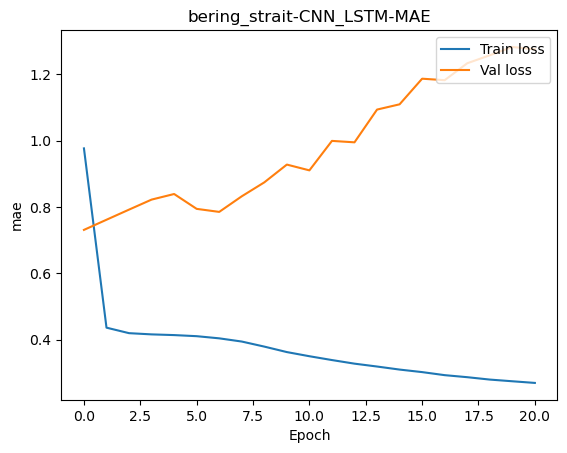

In [45]:
# set up title and ylabel strings
title_best = f"{active_site}-{method}-" + str(best_hps['loss']).upper()
ylabel_best = best_hps['loss']

title_top2 = f"{active_site}-{method}-" + str(best_hps['loss']).upper()
ylabel_top2 = top2_hps['loss']


# plot loss
#best
plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title(title_best, fontsize=12)
plt.ylabel(ylabel_best)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')
plt.show()

# #top2
# plt.plot(history_top2.history['loss'])
# plt.plot(history_top2.history['val_loss'])
# plt.title(title_top2, fontsize=12)
# plt.ylabel(ylabel_top2)
# plt.xlabel('Epoch')
# plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')
# plt.show()

In [46]:
model_path = os.path.join(cwd,'saved_model', active_site)
model_best.save(os.path.join(model_path,'CNN_LSTM_model_randomsearch_10trials_rank1.h5'))
model_top2.save(os.path.join(model_path,'CNN_LSTM_model_randomsearch_10trials_rank2.h5'))

#### Test Model
- NN
- NN + keras tuner
- CNN + keras tuner
- LSTM + keras tuner
- CNN_LSTM + keras tuner

##### NN

In [47]:
model_mse = load_model(os.path.join(model_path,'NN_mse_model.h5'))
model_mae = load_model(os.path.join(model_path,'NN_mae_model.h5'))


In [48]:
y_test_mse_pre = model_mse.predict(x_test_flattened)
y_test_mae_pre = model_mae.predict(x_test_flattened)

53/53 [==============================] - 0s 2ms/step


In [49]:
y_test_mse_pre = y_test_mse_pre.reshape(y_test_mse_pre.shape[0], n_lat, n_lon)
y_test_mse_pre = xr.Dataset(coords={'time': x_test_xr.time.values, 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_mse_pre)))

y_test_mae_pre = y_test_mae_pre.reshape(y_test_mae_pre.shape[0], n_lat, n_lon)
y_test_mae_pre = xr.Dataset(coords={'time': x_test_xr.time.values, 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_mae_pre)))


In [50]:
y_test_xr = xr.Dataset(coords={'time': y_test_xr.time.values, 
                                     'latitude': y_test_xr.latitude.values, 
                                     'longitude': y_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_np)))

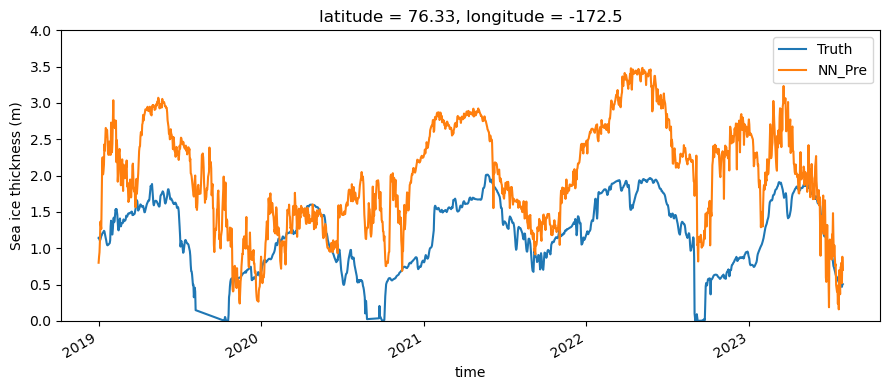

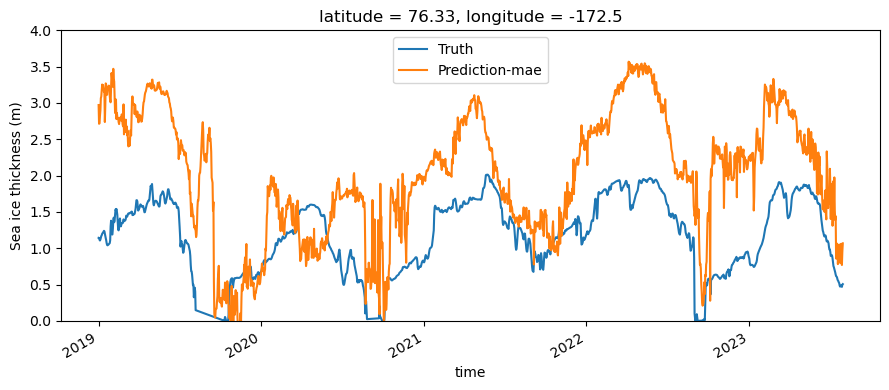

In [51]:
lat = 76.23
lon = -172.46
#mse
fig, ax = plt.subplots(figsize=(9, 4))
y_test_xr.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Truth')
y_test_mse_pre.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='NN_Pre')

ax.legend()
ax.set_ylabel('Sea ice thickness (m)') 
ax.set_ylim(0, 4)
plt.tight_layout()
plt.show()
#mae
fig, ax = plt.subplots(figsize=(9, 4))
y_test_xr.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Truth')
y_test_mae_pre.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Prediction-mae')

ax.set_ylim(0, 4)
ax.legend()
ax.set_ylabel('Sea ice thickness (m)') 

plt.tight_layout()
plt.show()

In [52]:
def global_mean_std_plot(X, label, color, ax, var='sithick'):
    weights = np.cos(np.deg2rad(X.latitude))
    sithick_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    sithick_std = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, sithick_mean, label=label, color=color, linewidth=2)
    ax.fill_between(x, sithick_mean+sithick_std, sithick_mean-sithick_std, facecolor=color, alpha=0.2)

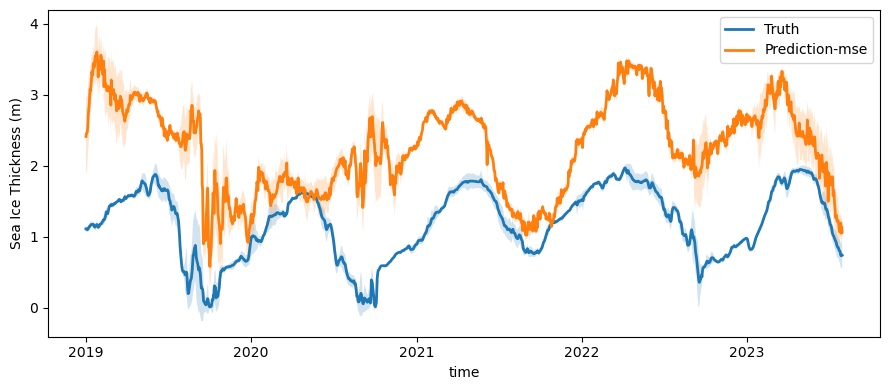

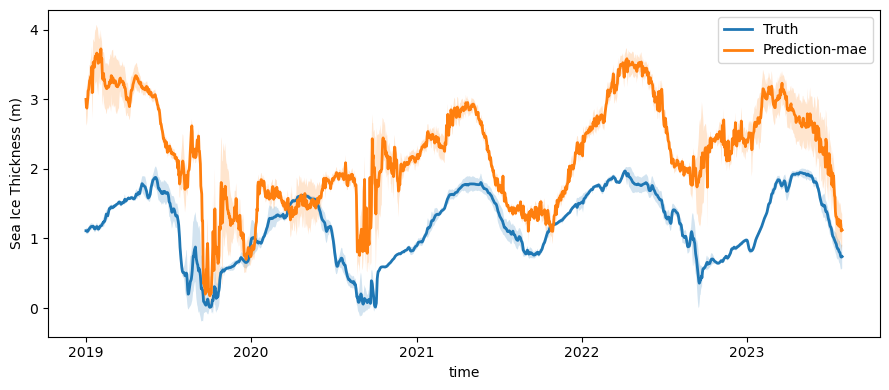

In [53]:
fig,ax = plt.subplots(figsize=(9,4))
#mse
global_mean_std_plot(y_test_xr,label='Truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_mse_pre,label='Prediction-mse',ax=ax,color='tab:orange')

ax.set_xlabel('time')
ax.set_ylabel('Sea Ice Thickness (m)')
ax.legend()
plt.tight_layout()

fig,ax = plt.subplots(figsize=(9,4))
#mae
global_mean_std_plot(y_test_xr,label='Truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_mae_pre,label='Prediction-mae',ax=ax,color='tab:orange')

ax.set_xlabel('time')
ax.set_ylabel('Sea Ice Thickness (m)')
ax.legend()
plt.tight_layout()

In [54]:
y_train_np = xr.Dataset(coords={'time': y_train_xr.time.values, 
                                     'latitude': y_train_xr.latitude.values, 
                                     'longitude': y_train_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_train_np)))
y_train_np

<xarray.Dataset>
Dimensions:    (time: 9496, latitude: 25, longitude: 25)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2018-12-31
  * latitude   (latitude) float32 76.33 76.42 76.5 76.58 ... 78.17 78.25 78.33
  * longitude  (longitude) float32 -174.4 -174.3 -174.2 ... -172.6 -172.5 -172.4
Data variables:
    sithick    (time, latitude, longitude) float32 2.66 2.66 ... 1.049 1.049

In [55]:
meanstd_outputs = {}
outputs = ["sithick"]

def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    normalized_data = (data - mean) / std
    return normalized_data

for var in outputs:  
    meanstd_outputs[var] = (y_test_xr[var].data.mean(), y_test_xr[var].data.std())


In [56]:
for var in outputs:

    # Normalize the test data
    var_dims = y_test_xr[var].dims
    y_test_xr_nor = y_test_xr.assign({var: (var_dims, normalize(y_test_xr[var].data, var, meanstd_outputs))})
    
    # Normalize the pre data
    var_dims = y_test_mse_pre.dims
    y_test_mse_pre_nor = y_test_mse_pre.assign({var: (var_dims, normalize(y_test_mse_pre[var].data, var, meanstd_outputs))})
    var_dims = y_test_mae_pre.dims
    y_test_mae_pre_nor = y_test_mae_pre.assign({var: (var_dims, normalize(y_test_mae_pre[var].data, var, meanstd_outputs))})
    
    print(var_dims)

Frozen({'time': 1673, 'latitude': 25, 'longitude': 25})


In [57]:
# specific date
from matplotlib.colors import LinearSegmentedColormap as color

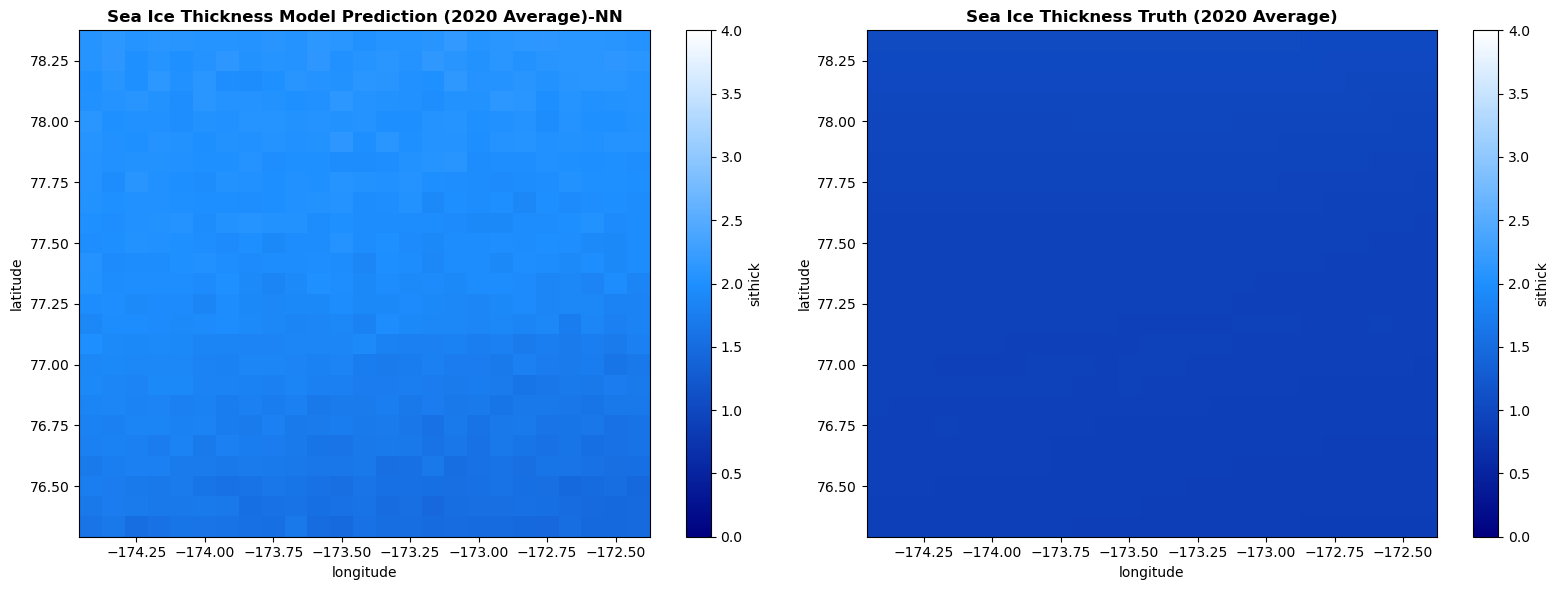

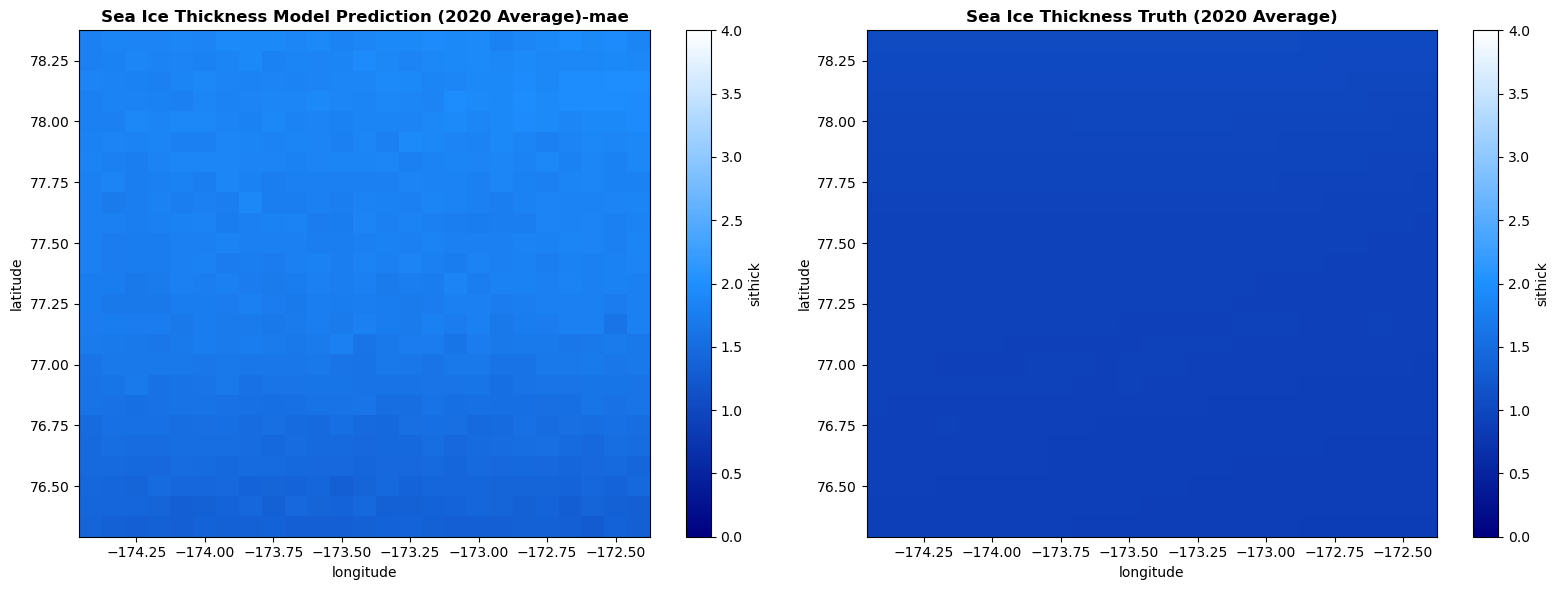

In [58]:
# 2020 average
vmin, vmax = 0, 4
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)

# MSE
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

mse_2020_mean = y_test_mse_pre.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_xr.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

mse_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)

axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-NN', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

# MAE
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

mae_2020_mean = y_test_mae_pre.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_xr.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

mae_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)

axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-mae', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

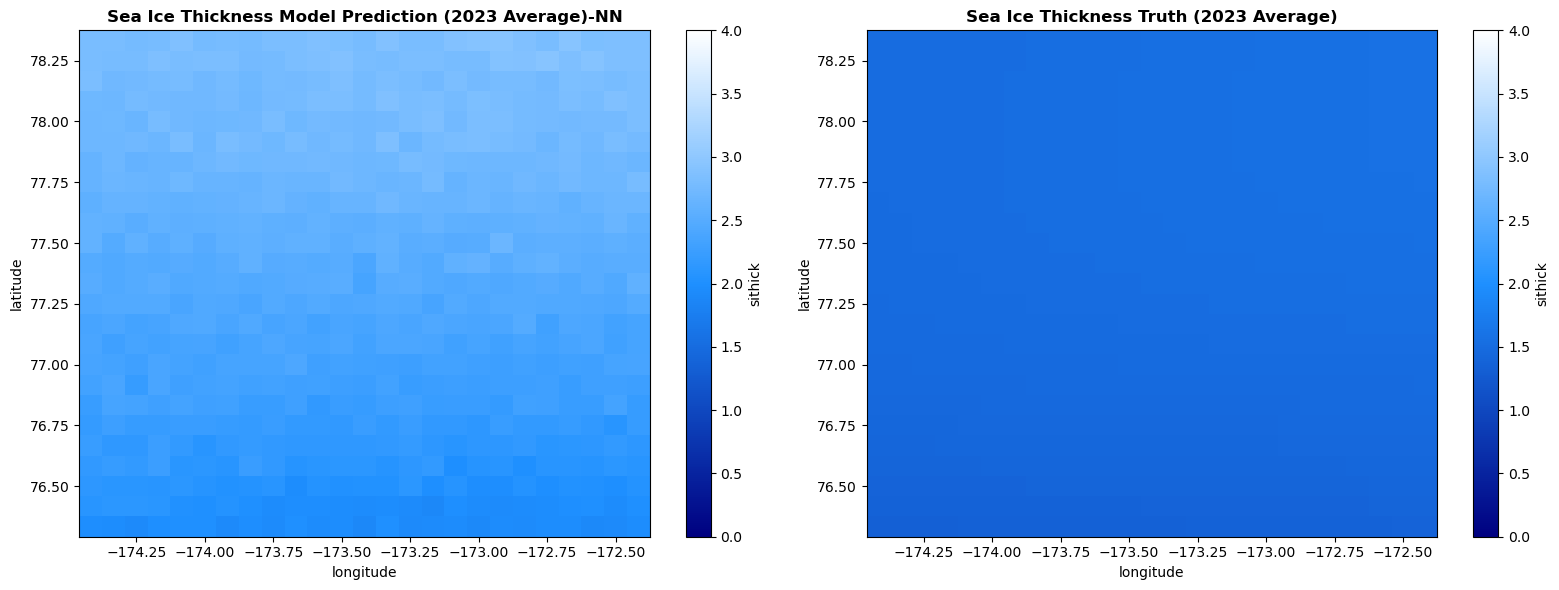

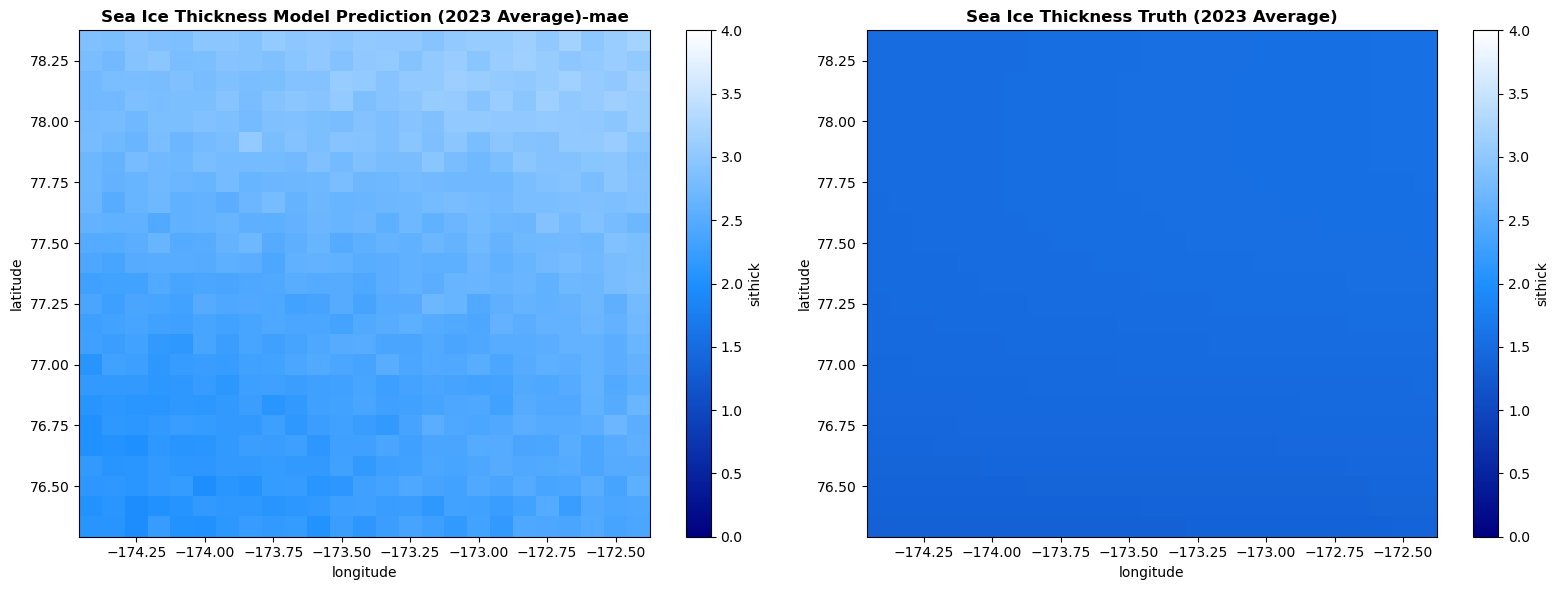

In [59]:
# 2023 average
vmin, vmax = 0, 4
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)


fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

mse_2023_mean = y_test_mse_pre.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')
np_2023_mean = y_test_xr.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')

mse_2023_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2023_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)

axes[0].set_title('Sea Ice Thickness Model Prediction (2023 Average)-NN', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2023 Average)', fontweight='bold')

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

mae_2023_mean = y_test_mae_pre.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')
np_2023_mean = y_test_xr.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')

mae_2023_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2023_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)

axes[0].set_title('Sea Ice Thickness Model Prediction (2023 Average)-mae', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2023 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

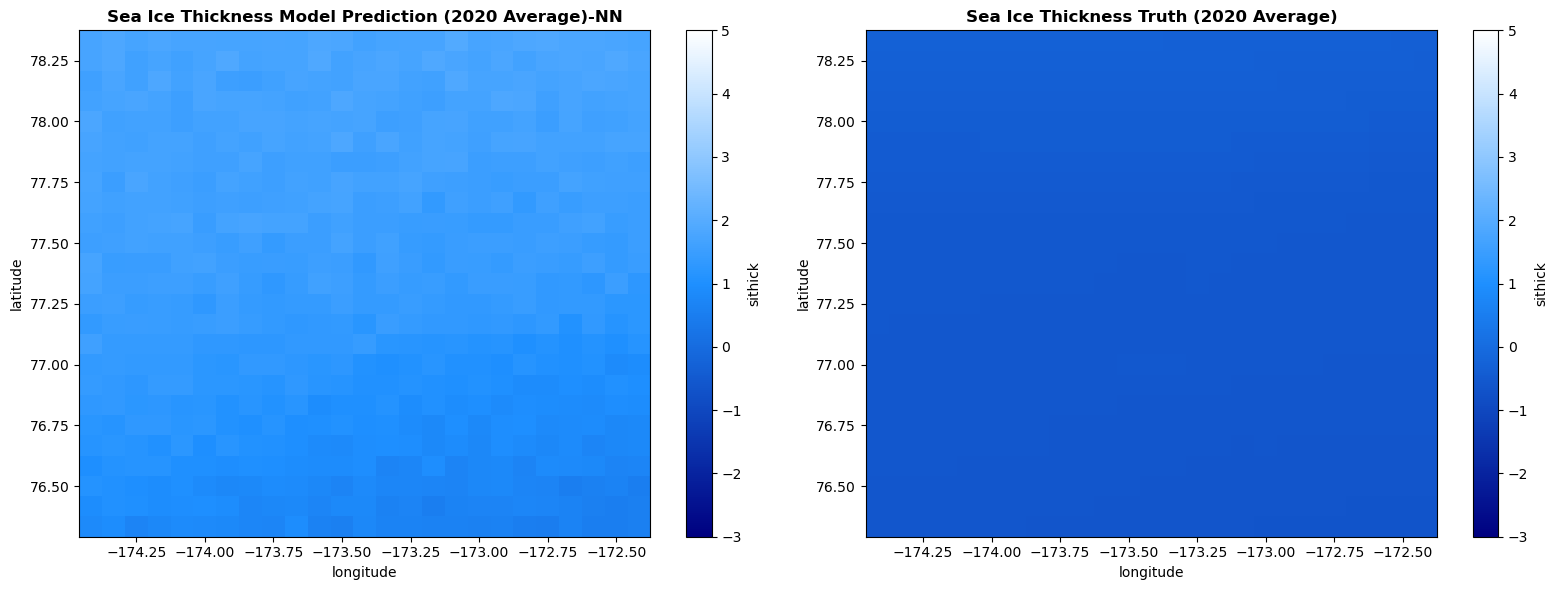

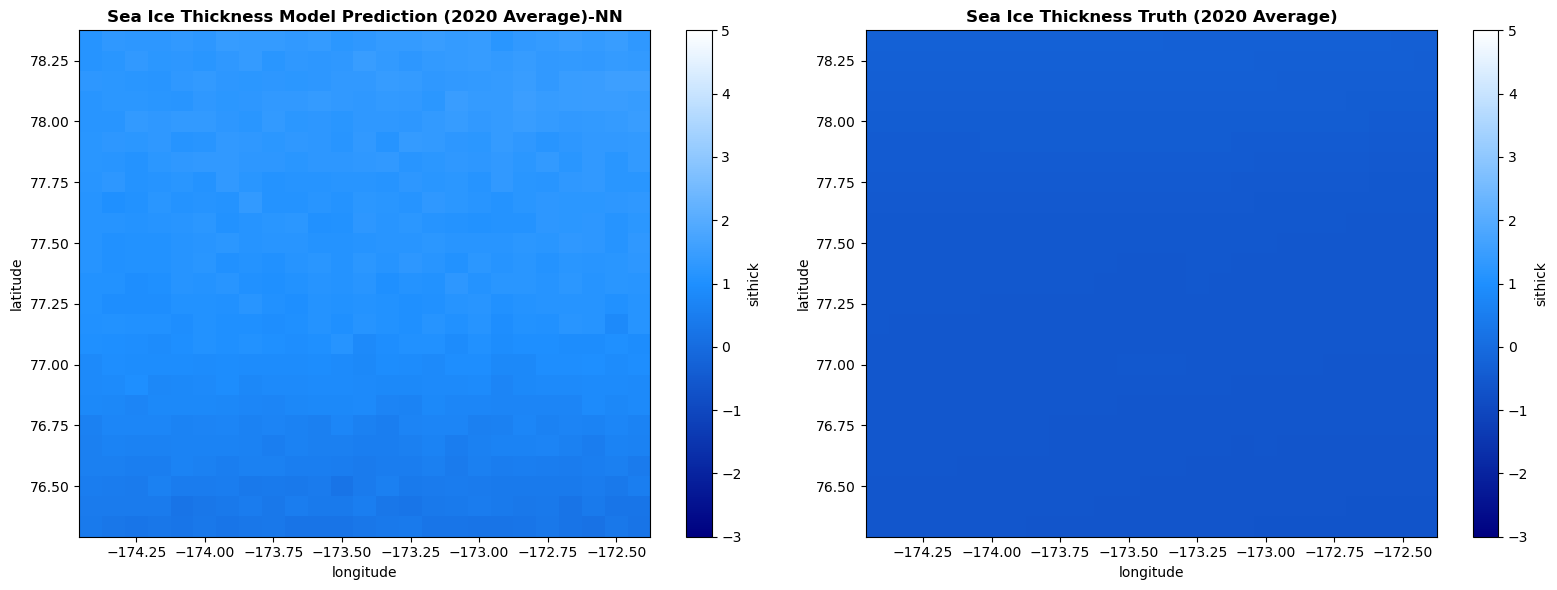

In [60]:
# with normalization 2020 average

vmin, vmax = -3, 5
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)


fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

mse_2020_mean = y_test_mse_pre_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_xr_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

mse_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-NN', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

mae_2020_mean = y_test_mae_pre_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_xr_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

mae_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-NN', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

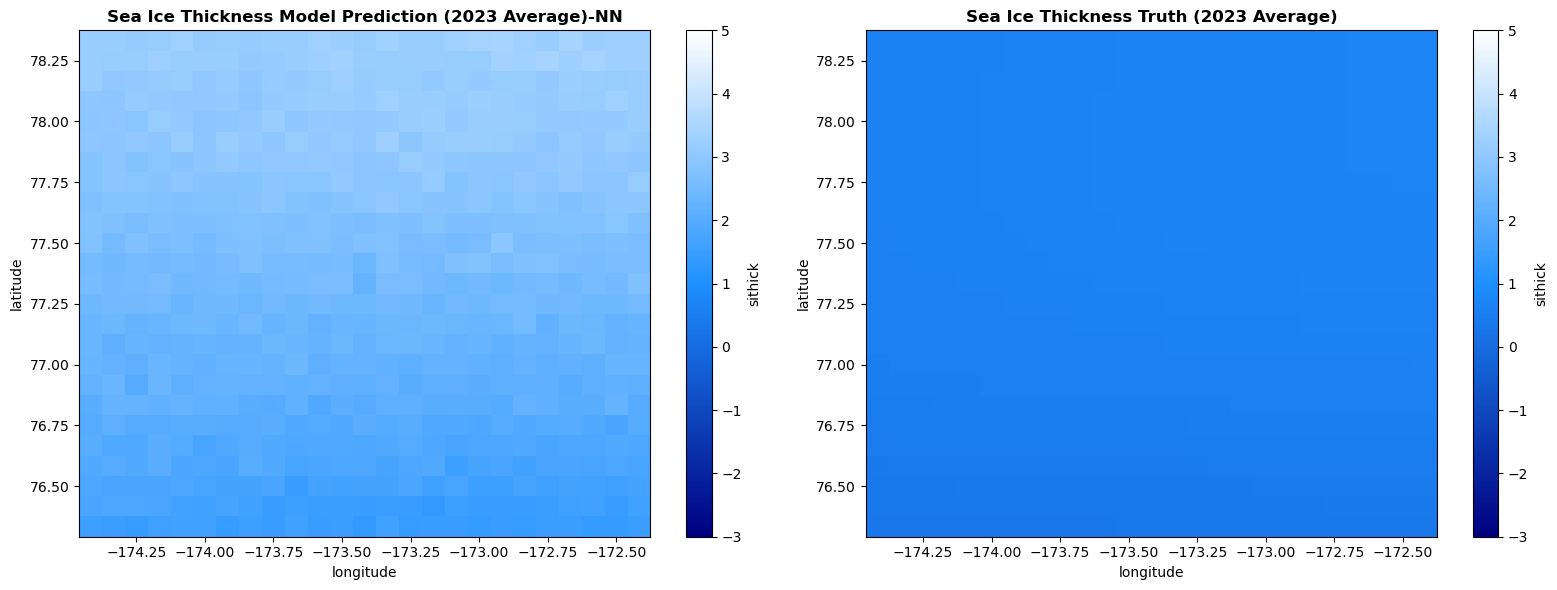

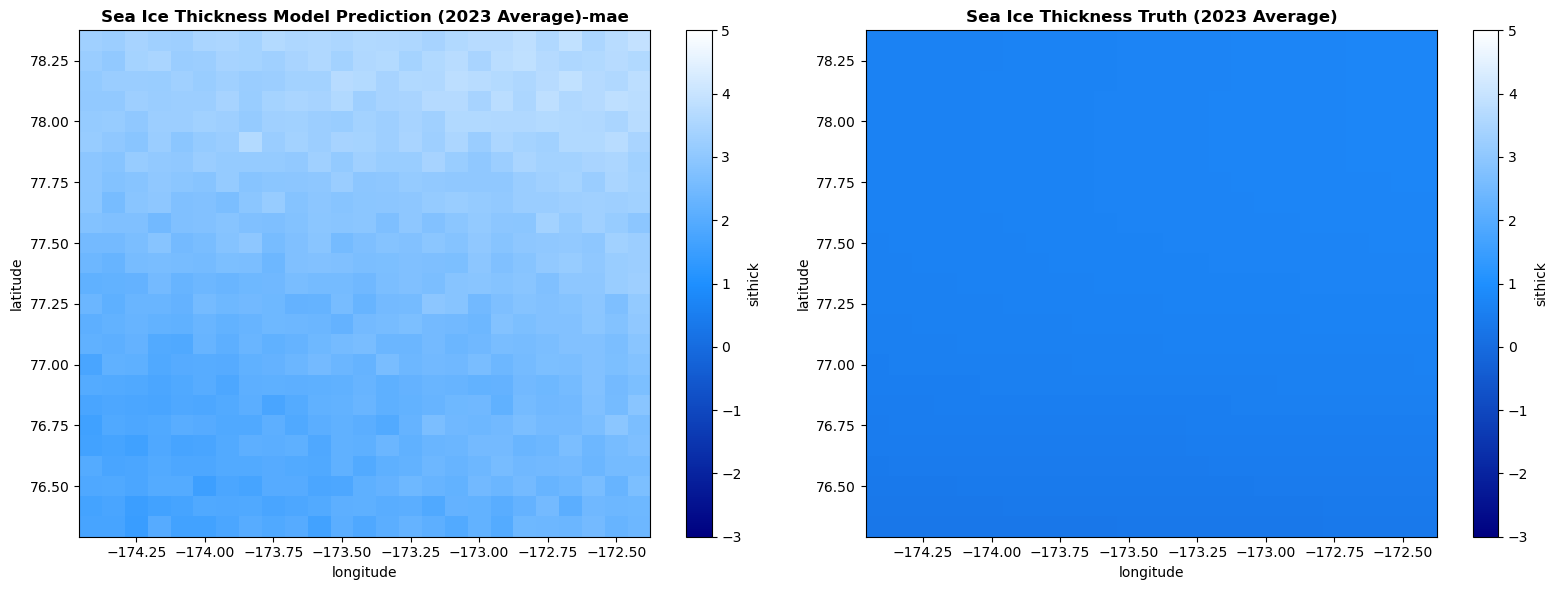

In [61]:
# with normalization 2023 average

vmin, vmax = -3, 5
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)


fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

mse_2023_mean = y_test_mse_pre_nor.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')
np_2023_mean = y_test_xr_nor.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')

mse_2023_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2023_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2023 Average)-NN', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2023 Average)', fontweight='bold')

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

mae_2023_mean = y_test_mae_pre_nor.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')
np_2023_mean = y_test_xr_nor.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')

mae_2023_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2023_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2023 Average)-mae', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2023 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

##### CNN + keras tuner

In [62]:
## reload the saved model
model_best = load_model(os.path.join(model_path,'CNN_model_randomsearch_10trials_rank1.h5'))
model_top2 = load_model(os.path.join(model_path,'CNN_model_randomsearch_10trials_rank2.h5'))


In [63]:
y_test_best_pre = model_best.predict(x_test_np)
y_test_best_pre = y_test_best_pre.reshape(y_test_best_pre.shape[0], n_lat, n_lon)
y_test_best_pre = xr.Dataset(coords={'time': x_test_xr.time.values, 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_best_pre)))
# ---------- rank #2 tuning ----------
y_test_top2_pre = model_top2.predict(x_test_np)
y_test_top2_pre = y_test_top2_pre.reshape(y_test_top2_pre.shape[0], n_lat, n_lon)
y_test_top2_pre = xr.Dataset(coords={'time': x_test_xr.time.values, 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_top2_pre)))


53/53 [==============================] - 2s 39ms/step


In [64]:
y_test_best_pre

<xarray.Dataset>
Dimensions:    (time: 1673, latitude: 25, longitude: 25)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2023-07-31
  * latitude   (latitude) float32 76.33 76.42 76.5 76.58 ... 78.17 78.25 78.33
  * longitude  (longitude) float32 -174.4 -174.3 -174.2 ... -172.6 -172.5 -172.4
Data variables:
    sithick    (time, latitude, longitude) float32 1.563 2.147 ... 3.083 3.06

<xarray.Dataset>
Dimensions:    (time: 1673, latitude: 25, longitude: 25)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2023-07-31
  * latitude   (latitude) float32 76.33 76.42 76.5 76.58 ... 78.17 78.25 78.33
  * longitude  (longitude) float32 -174.4 -174.3 -174.2 ... -172.6 -172.5 -172.4
Data variables:
    sithick    (time, latitude, longitude) float32 1.563 2.147 ... 3.083 3.06


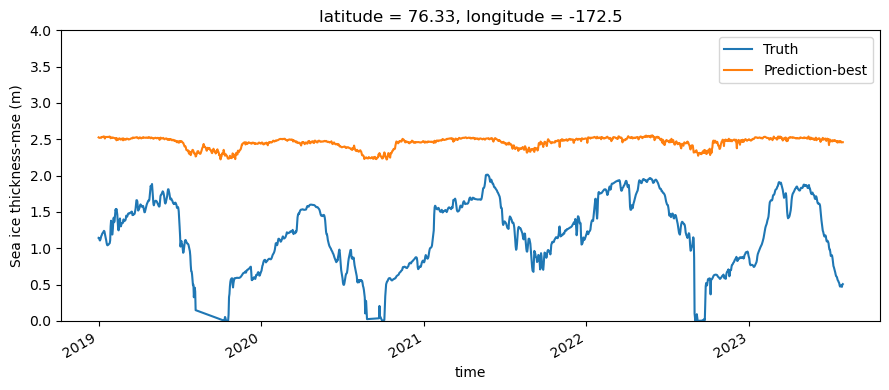

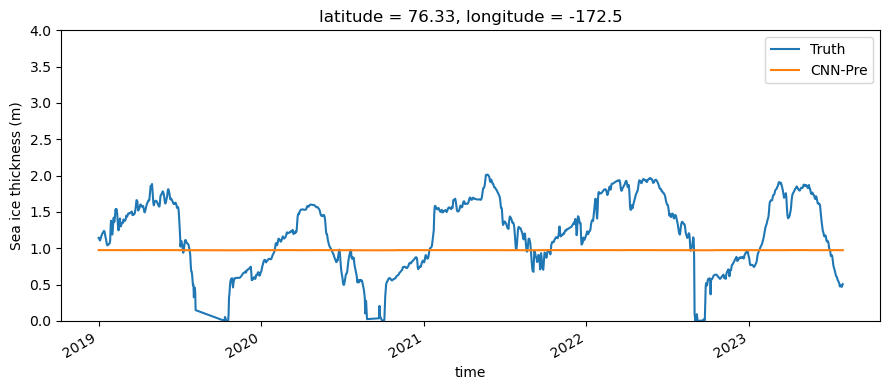

In [66]:
print(y_test_best_pre)
lat = 76.23
lon = -172.46
#best
fig, ax = plt.subplots(figsize=(9, 4))
y_test_xr.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Truth')
y_test_best_pre.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Prediction-best')
ax.set_ylim(0, 4)
ax.legend()
ax.set_ylabel('Sea ice thickness-mse (m)') 

plt.tight_layout()
plt.show()
#top2
fig, ax = plt.subplots(figsize=(9, 4))
y_test_xr.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Truth')
y_test_top2_pre.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='CNN-Pre')

ax.set_ylim(0, 4)
ax.legend()
ax.set_ylabel('Sea ice thickness (m)') 

plt.tight_layout()
plt.show()

In [67]:
meanstd_outputs = {}
outputs = ["sithick"]

def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    normalized_data = (data - mean) / std
    return normalized_data

for var in outputs:  
    meanstd_outputs[var] = (y_test_xr[var].data.mean(), y_test_xr[var].data.std())

In [68]:
for var in outputs:  
    
    print(f"Working on variable: {var}")
    print("Contents of meanstd_outputs dictionary:", meanstd_outputs)
    
    # Normalize the pre data
    var_dims = y_test_best_pre.dims
    y_test_best_pre_nor = y_test_best_pre.assign({var: (var_dims, normalize(y_test_best_pre[var].data, var, meanstd_outputs))})
    var_dims = y_test_top2_pre.dims
    y_test_top2_pre_nor = y_test_top2_pre.assign({var: (var_dims, normalize(y_test_top2_pre[var].data, var, meanstd_outputs))})

Working on variable: sithick
Contents of meanstd_outputs dictionary: {'sithick': (1.1953518, 0.5073721)}


In [69]:
from matplotlib.colors import LinearSegmentedColormap as color

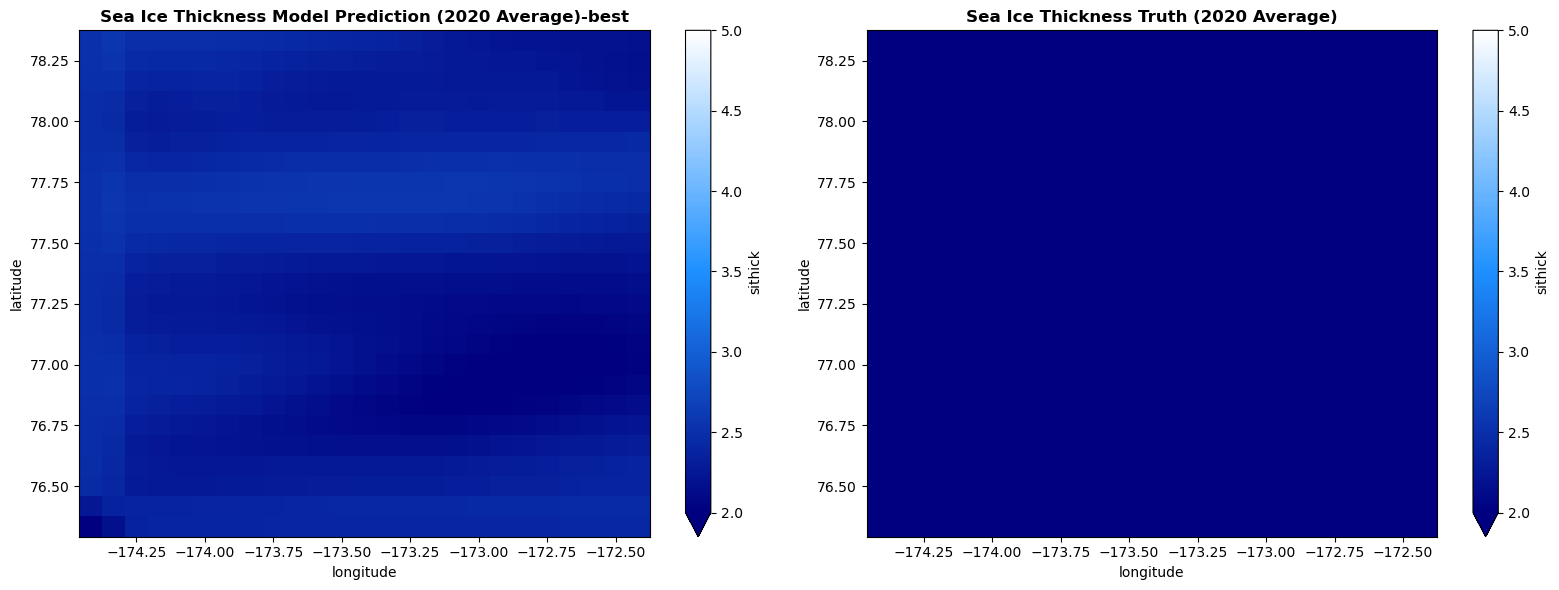

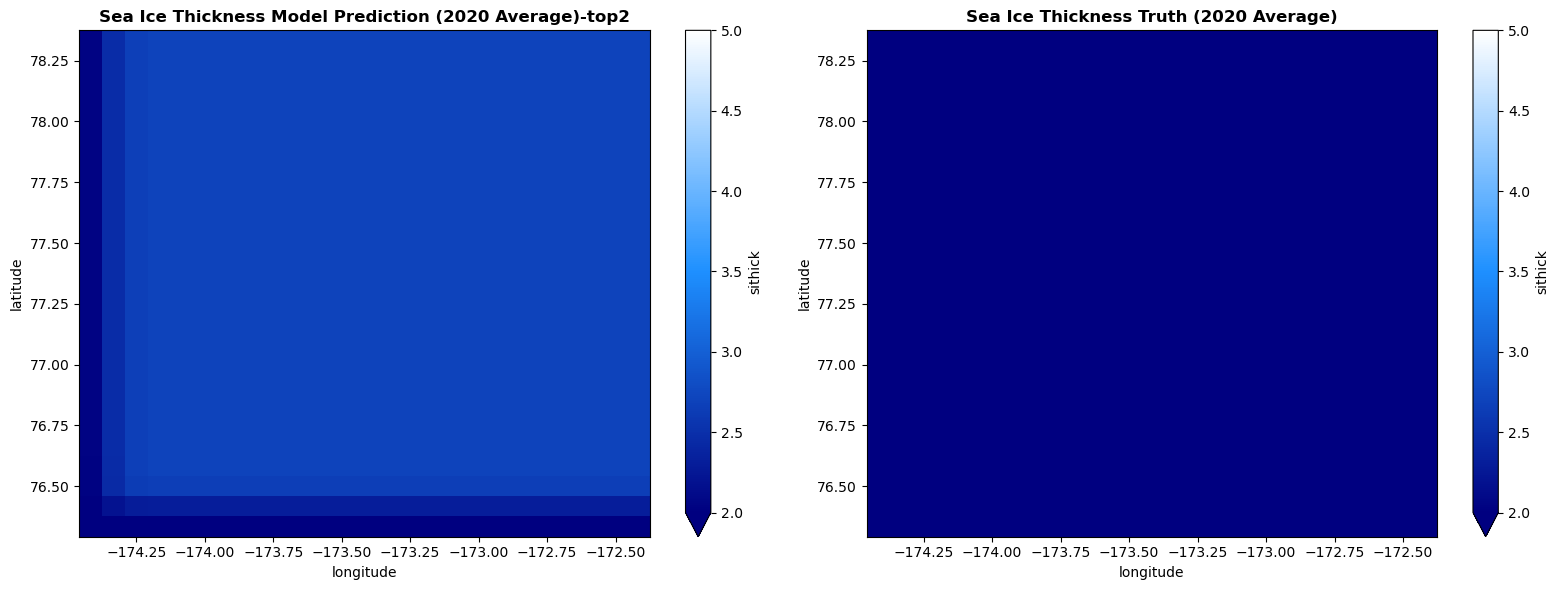

In [70]:
# 2020 average
vmin, vmax = 2, 5
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)


fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

best_2020_mean = y_test_best_pre.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_xr.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

best_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)

axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-best', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

top2_2020_mean = y_test_top2_pre.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_xr.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

top2_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)

axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-top2', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

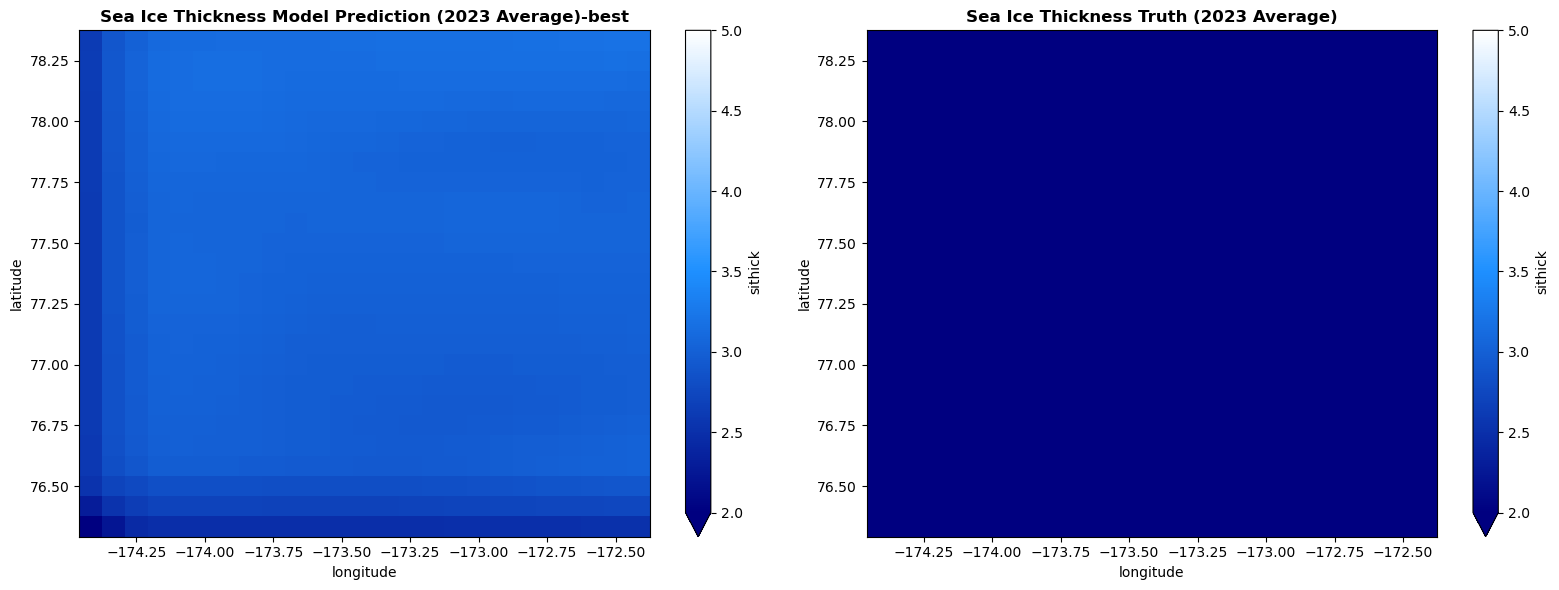

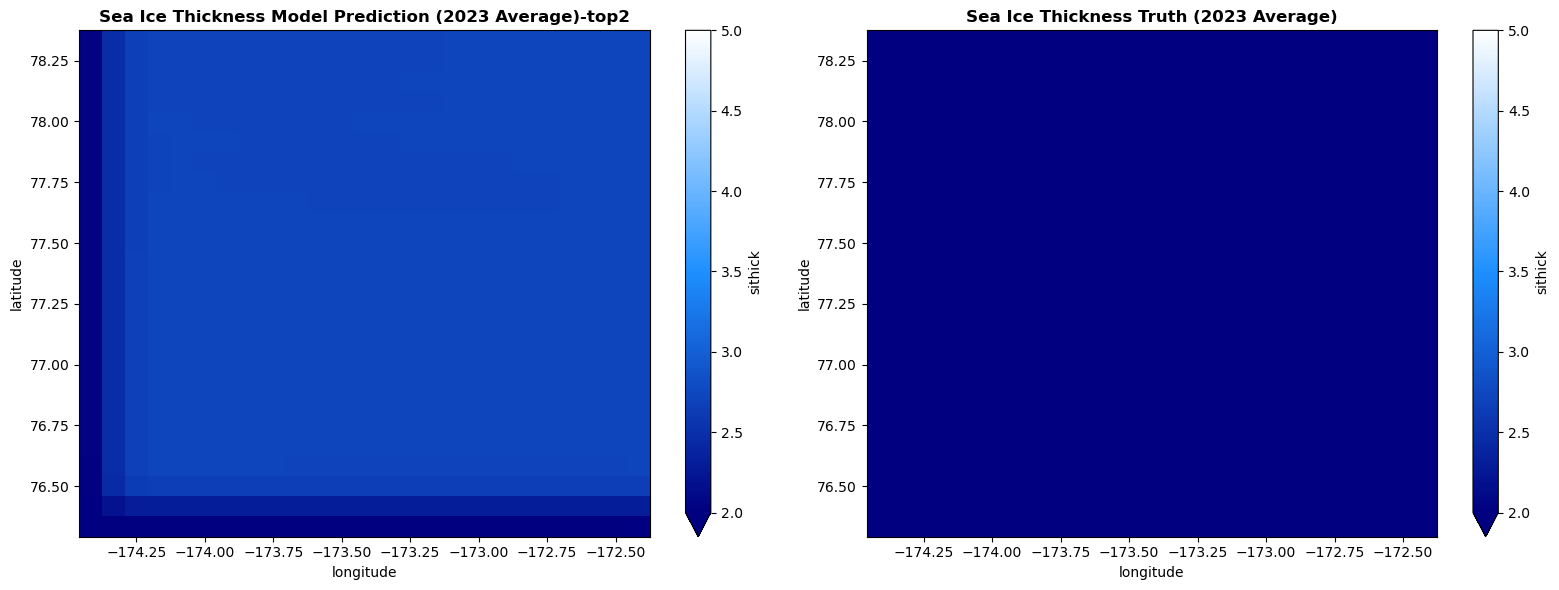

In [71]:
# 2023 average
vmin, vmax = 2, 5
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)


fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

best_2023_mean = y_test_best_pre.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')
np_2023_mean = y_test_xr.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')

best_2023_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2023_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)

axes[0].set_title('Sea Ice Thickness Model Prediction (2023 Average)-best', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2023 Average)', fontweight='bold')

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

top2_2023_mean = y_test_top2_pre.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')
np_2023_mean = y_test_xr.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')

top2_2023_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2023_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)

axes[0].set_title('Sea Ice Thickness Model Prediction (2023 Average)-top2', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2023 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

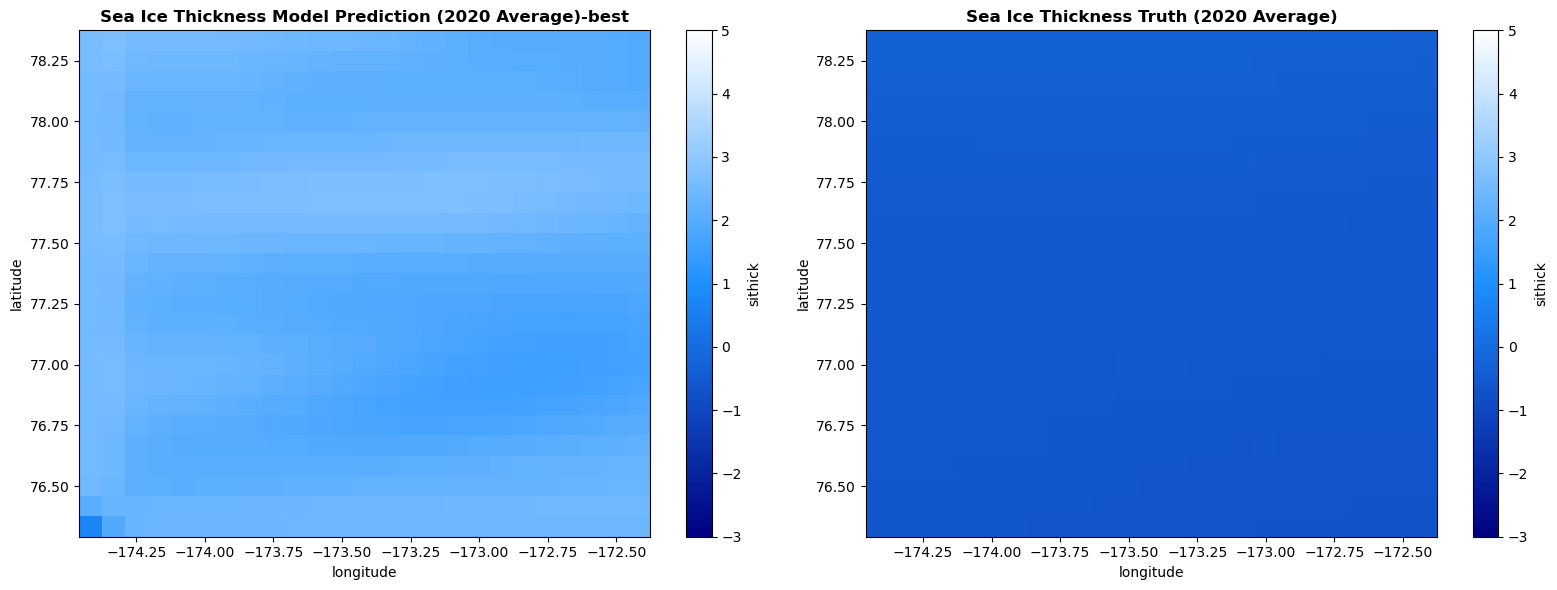

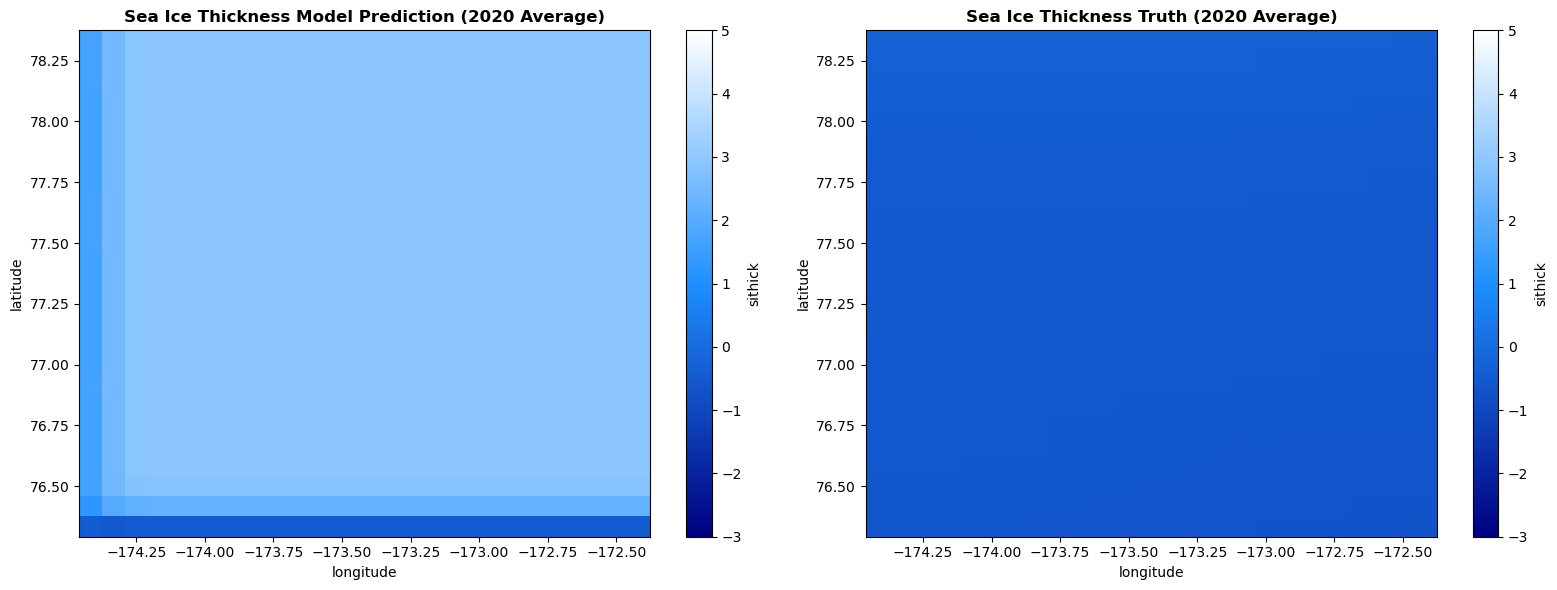

In [72]:
# with normalization 2020 average

vmin, vmax = -3, 5
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)

# best
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

best_2020_mean = y_test_best_pre_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_xr_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

best_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-best', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

# top2
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

top2_2020_mean = y_test_top2_pre_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_xr_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

top2_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

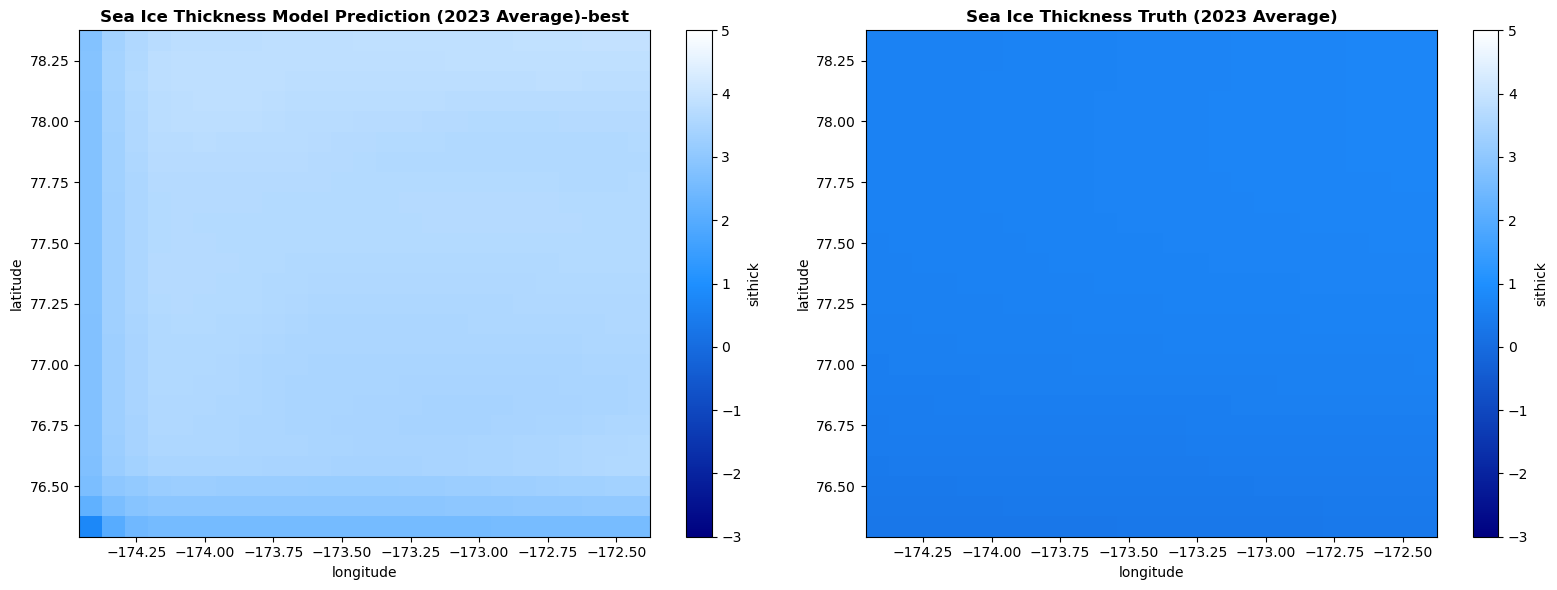

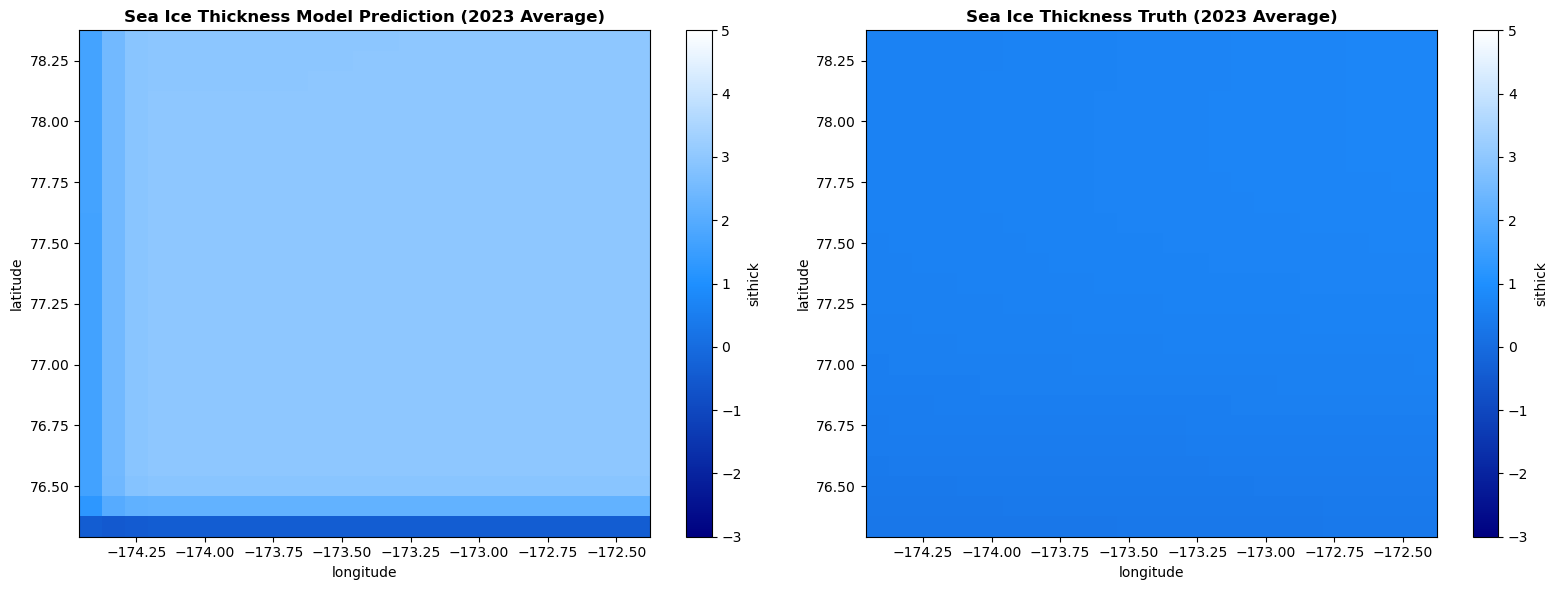

In [74]:
# with normalization 2023 average

vmin, vmax = -3, 5
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)

# best
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

best_2023_mean = y_test_best_pre_nor.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')
np_2023_mean = y_test_xr_nor.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')

best_2023_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2023_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2023 Average)-best', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2023 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

# top2
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

top2_2023_mean = y_test_top2_pre_nor.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')
np_2023_mean = y_test_xr_nor.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')

top2_2023_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2023_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2023 Average)', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2023 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

##### LSTM + keras tuner

In [75]:
## reload the saved model
model_best = load_model(os.path.join(model_path,'LSTM_model_randomsearch_12trials_rank1.h5'))
model_top2 = load_model(os.path.join(model_path,'LSTM_model_randomsearch_12trials_rank2.h5'))


2023-12-22 21:54:00.901556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-22 21:54:00.902855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-22 21:54:00.903747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [76]:
y_test_best_pre = model_best.predict(x_test_slider)
y_test_best_pre = y_test_best_pre.reshape(y_test_best_pre.shape[0], n_lat, n_lon)
y_test_best_pre = xr.Dataset(coords={'time': x_test_xr.time.values[slider-1:], 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_best_pre)))
# ---------- rank #2 tuning ----------
y_test_top2_pre = model_top2.predict(x_test_slider)
y_test_top2_pre = y_test_top2_pre.reshape(y_test_top2_pre.shape[0], n_lat, n_lon)
y_test_top2_pre = xr.Dataset(coords={'time': x_test_xr.time.values[slider-1:], 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_top2_pre)))

2023-12-22 21:54:01.853329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-22 21:54:01.854696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-22 21:54:01.855789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/53 [..............................] - ETA: 41s

2023-12-22 21:54:02.341034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-22 21:54:02.342427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-22 21:54:02.343380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

53/53 [==============================] - 1s 7ms/step


<xarray.Dataset>
Dimensions:    (time: 1669, latitude: 25, longitude: 25)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-05 2019-01-06 ... 2023-07-31
  * latitude   (latitude) float32 76.33 76.42 76.5 76.58 ... 78.17 78.25 78.33
  * longitude  (longitude) float32 -174.4 -174.3 -174.2 ... -172.6 -172.5 -172.4
Data variables:
    sithick    (time, latitude, longitude) float32 2.026 1.938 ... -0.004025


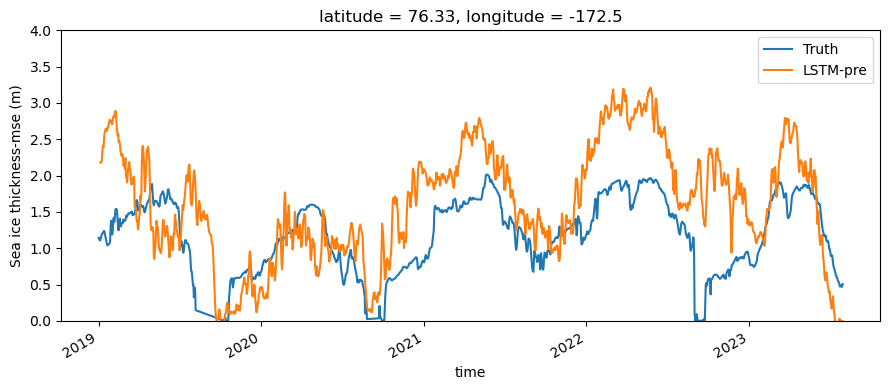

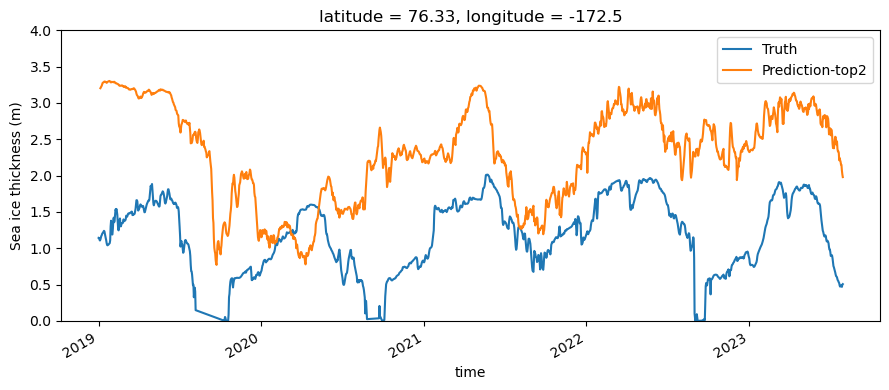

In [77]:
print(y_test_best_pre)
lat = 76.23
lon = -172.46
#best
fig, ax = plt.subplots(figsize=(9, 4))
y_test_xr.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Truth')
y_test_best_pre.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='LSTM-pre')
ax.set_ylim(0, 4)
ax.legend()
ax.set_ylabel('Sea ice thickness-mse (m)') 

plt.tight_layout()
plt.show()
#top2
fig, ax = plt.subplots(figsize=(9, 4))
y_test_xr.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Truth')
y_test_top2_pre.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Prediction-top2')
ax.set_ylim(0, 4)
ax.legend()
ax.set_ylabel('Sea ice thickness (m)') 

plt.tight_layout()
plt.show()

In [78]:
meanstd_outputs = {}
outputs = ["sithick"]

def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    normalized_data = (data - mean) / std
    return normalized_data

for var in outputs:  
    meanstd_outputs[var] = (y_test_xr[var].data.mean(), y_test_xr[var].data.std())

for var in outputs:  

    print(f"Working on variable: {var}")
    print("Contents of meanstd_outputs dictionary:", meanstd_outputs)

    # Normalize the pre data
    var_dims = y_test_best_pre.dims
    y_test_best_pre_nor = y_test_best_pre.assign({var: (var_dims, normalize(y_test_best_pre[var].data, var, meanstd_outputs))})
    var_dims = y_test_top2_pre.dims
    y_test_top2_pre_nor = y_test_top2_pre.assign({var: (var_dims, normalize(y_test_top2_pre[var].data, var, meanstd_outputs))})

Working on variable: sithick
Contents of meanstd_outputs dictionary: {'sithick': (1.1953518, 0.5073721)}


In [79]:
from matplotlib.colors import LinearSegmentedColormap as color

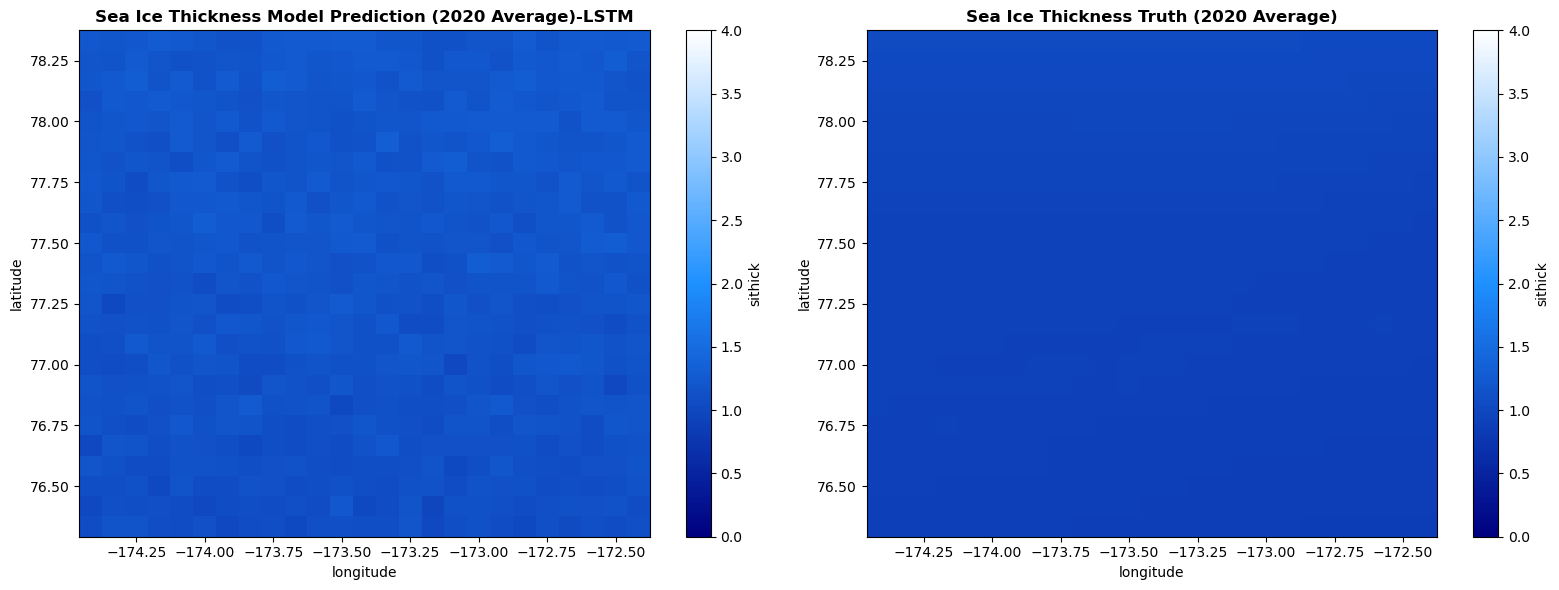

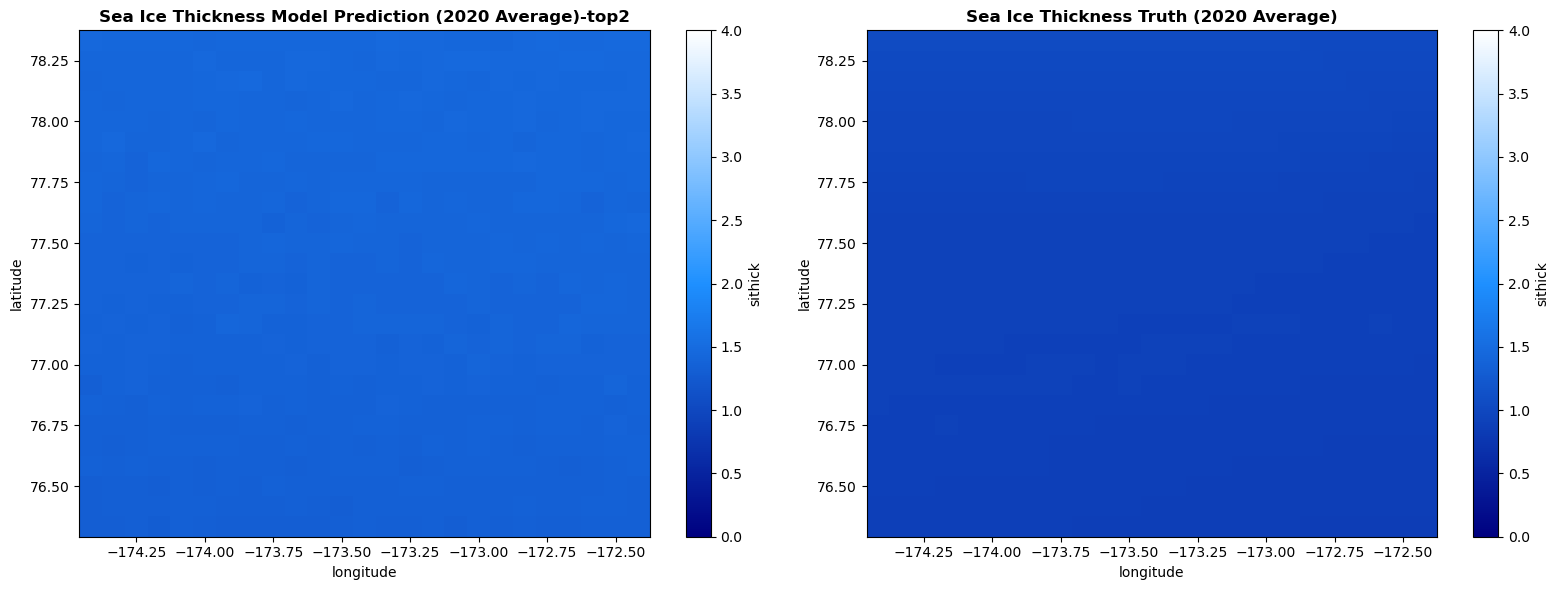

In [80]:
# 2020 average
vmin, vmax = 0, 4
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)


fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

best_2020_mean = y_test_best_pre.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_xr.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

best_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)

axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-LSTM', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

top2_2020_mean = y_test_top2_pre.sithick.sel(time=slice("2020-01-01", "2020-7-31")).mean(dim='time')
np_2020_mean = y_test_xr.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

top2_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)

axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-top2', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')
plt.tight_layout()
plt.show()

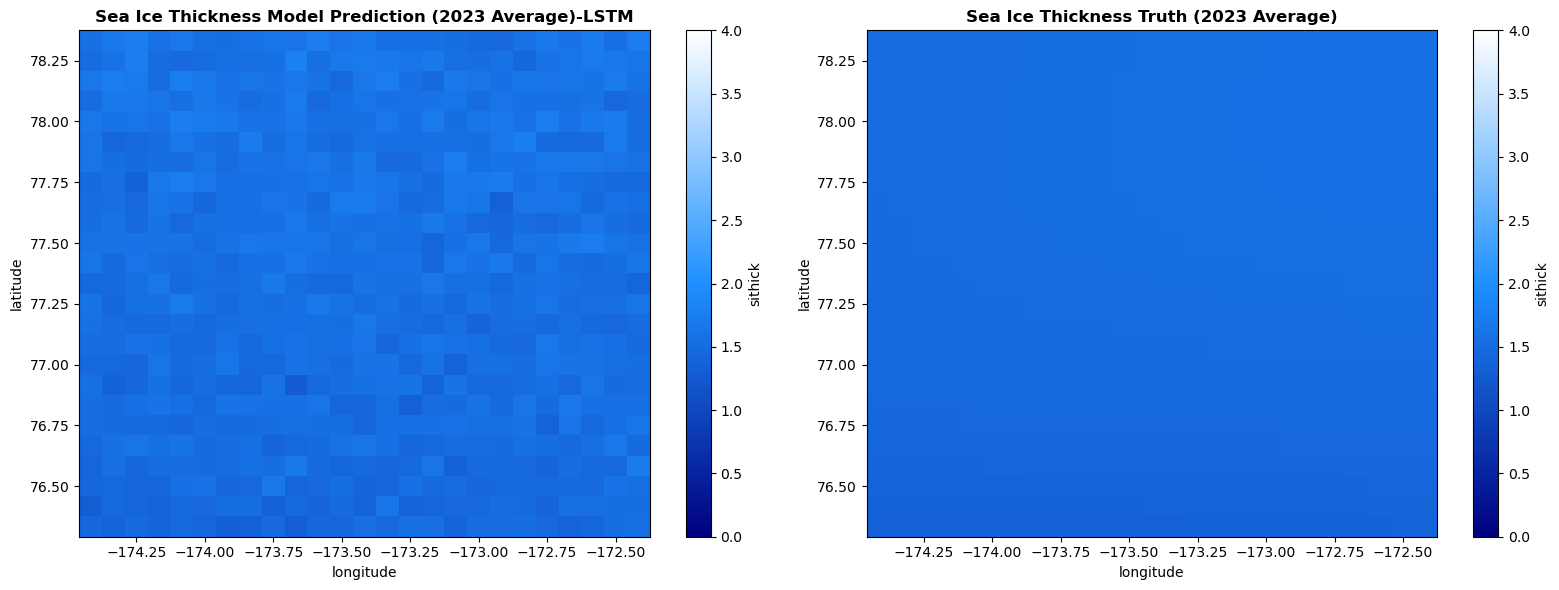

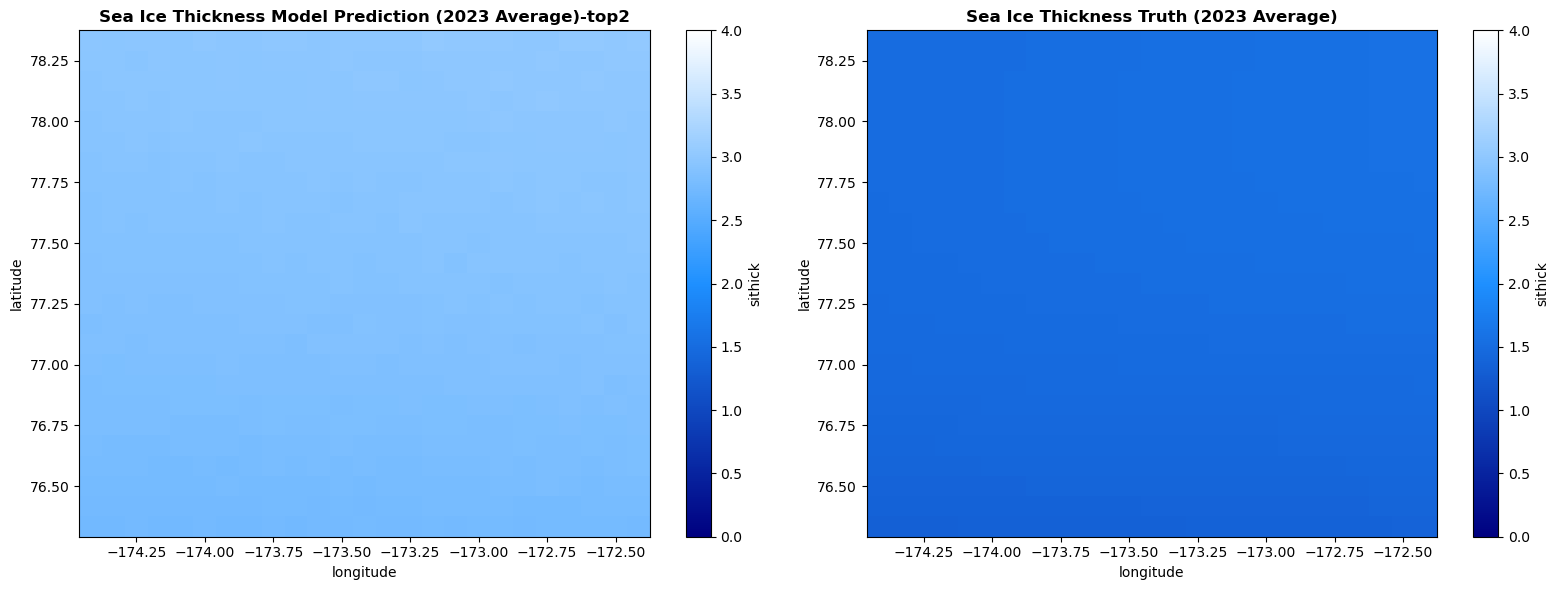

In [81]:
# 2023 average
vmin, vmax = 0, 4
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)


fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

best_2023_mean = y_test_best_pre.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')
np_2023_mean = y_test_xr.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')

best_2023_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2023_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)

axes[0].set_title('Sea Ice Thickness Model Prediction (2023 Average)-LSTM', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2023 Average)', fontweight='bold')

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

top2_2023_mean = y_test_top2_pre.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')
np_2023_mean = y_test_xr.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')

top2_2023_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2023_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)

axes[0].set_title('Sea Ice Thickness Model Prediction (2023 Average)-top2', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2023 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

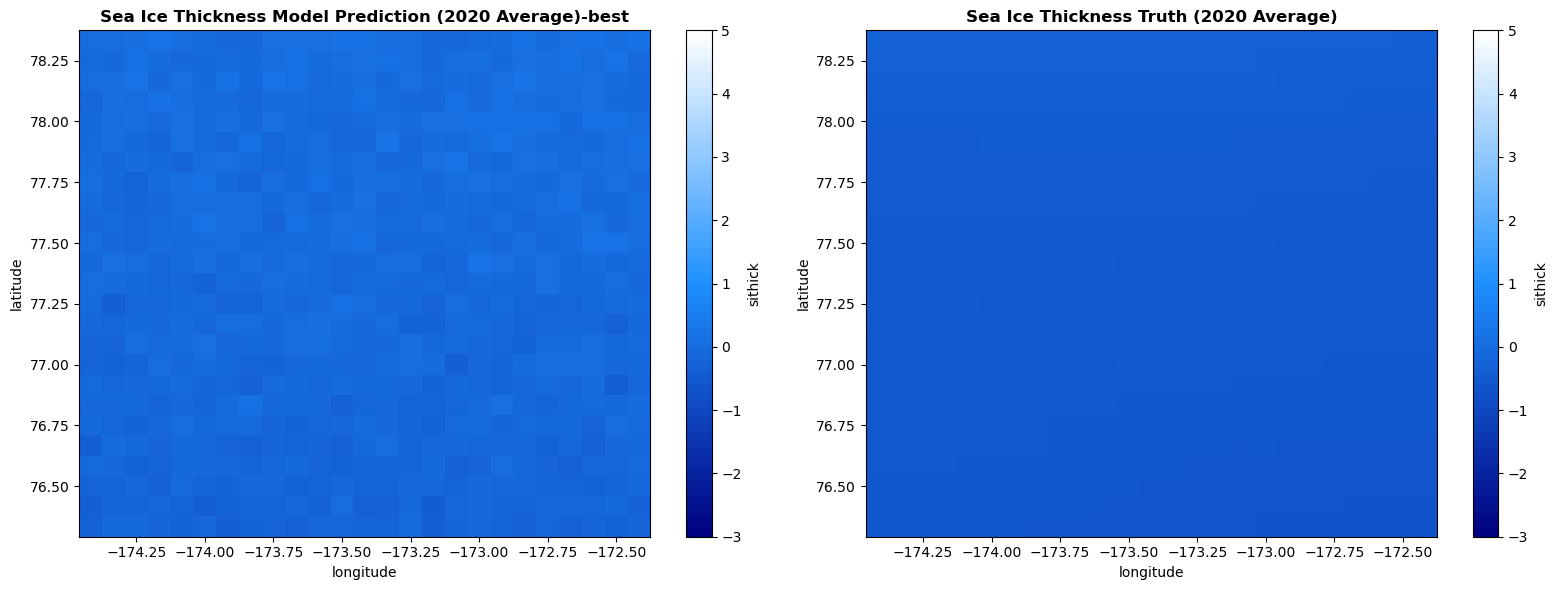

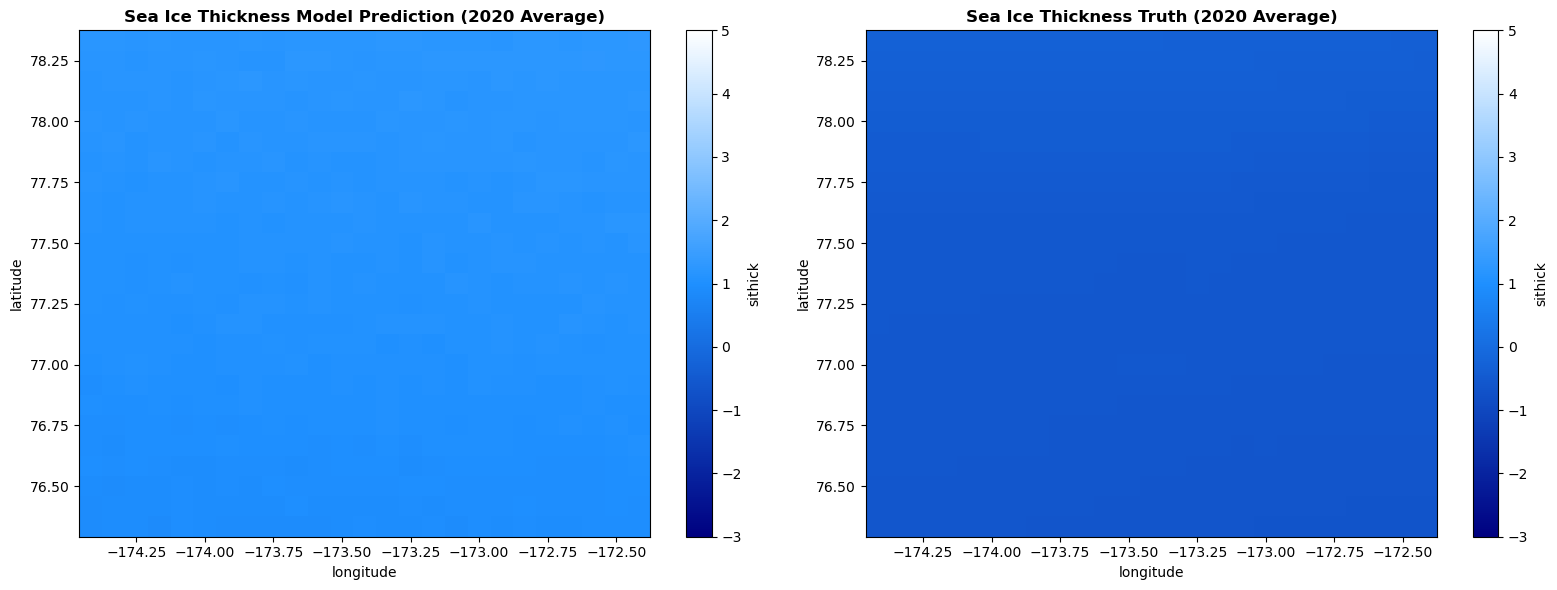

In [82]:
# with normalization 2020 average

vmin, vmax = -3, 5
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)

# best
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

best_2020_mean = y_test_best_pre_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_xr_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

best_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-best', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

# top2
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

top2_2020_mean = y_test_top2_pre_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_xr_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

top2_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

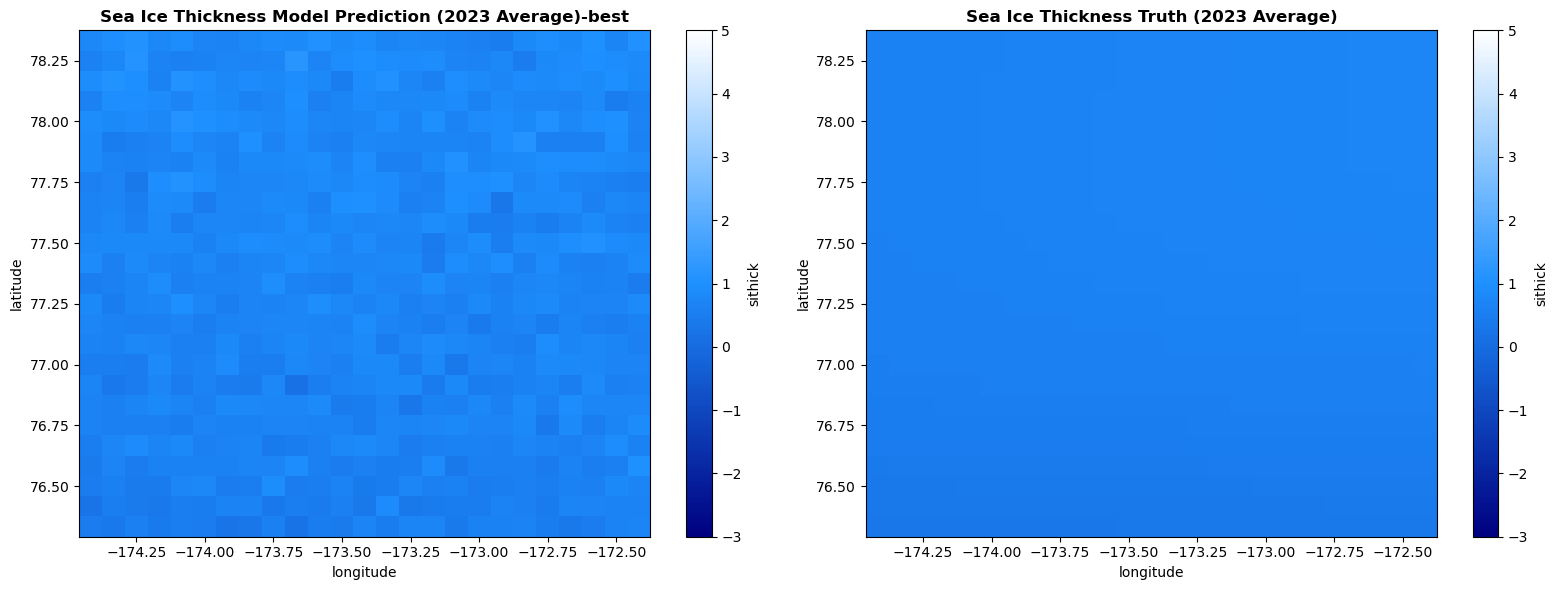

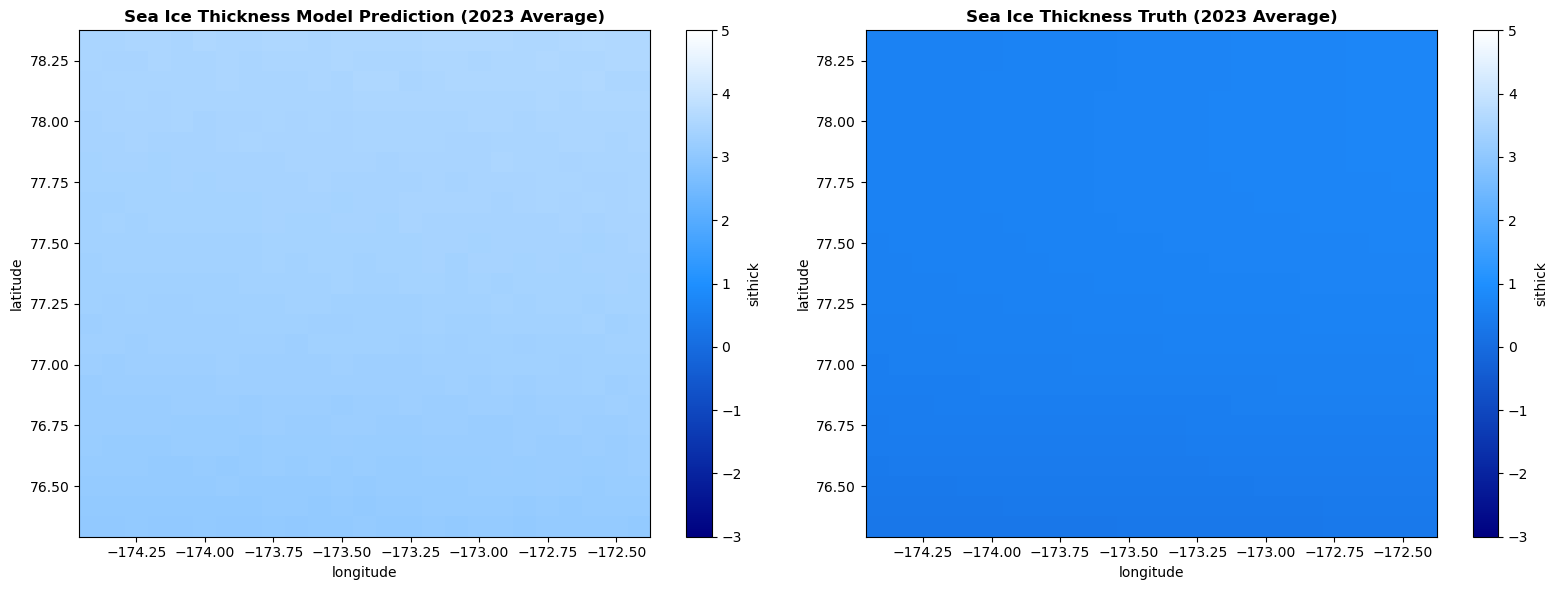

In [83]:
# with normalization 2023 average

vmin, vmax = -3, 5
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)

# best
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

best_2023_mean = y_test_best_pre_nor.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')
np_2023_mean = y_test_xr_nor.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')

best_2023_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2023_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2023 Average)-best', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2023 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

# top2
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

top2_2023_mean = y_test_top2_pre_nor.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')
np_2023_mean = y_test_xr_nor.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')

top2_2023_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2023_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2023 Average)', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2023 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

##### CNN_LSTM + keras tuner

In [84]:
model_best = load_model(os.path.join(model_path,'CNN_LSTM_model_randomsearch_10trials_rank1.h5'))
model_top2 = load_model(os.path.join(model_path,'CNN_LSTM_model_randomsearch_10trials_rank2.h5'))

2023-12-22 21:54:10.491467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-22 21:54:10.492956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-22 21:54:10.494056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [85]:
y_test_best_pre = model_best.predict(x_test_slider)
y_test_best_pre = y_test_best_pre.reshape(y_test_best_pre.shape[0], n_lat, n_lon)
y_test_best_pre = xr.Dataset(coords={'time': x_test_xr.time.values[slider-1:], 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_best_pre)))
# ---------- rank #2 tuning ----------
y_test_top2_pre = model_top2.predict(x_test_slider)
y_test_top2_pre = y_test_top2_pre.reshape(y_test_top2_pre.shape[0], n_lat, n_lon)
y_test_top2_pre = xr.Dataset(coords={'time': x_test_xr.time.values[slider-1:], 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_top2_pre)))

 1/53 [..............................] - ETA: 14s

2023-12-22 21:54:13.439864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-22 21:54:13.441177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-22 21:54:13.442059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

53/53 [==============================] - 2s 25ms/step


<xarray.Dataset>
Dimensions:    (time: 1669, latitude: 25, longitude: 25)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-05 2019-01-06 ... 2023-07-31
  * latitude   (latitude) float32 76.33 76.42 76.5 76.58 ... 78.17 78.25 78.33
  * longitude  (longitude) float32 -174.4 -174.3 -174.2 ... -172.6 -172.5 -172.4
Data variables:
    sithick    (time, latitude, longitude) float32 2.62 2.609 ... 2.682 2.691


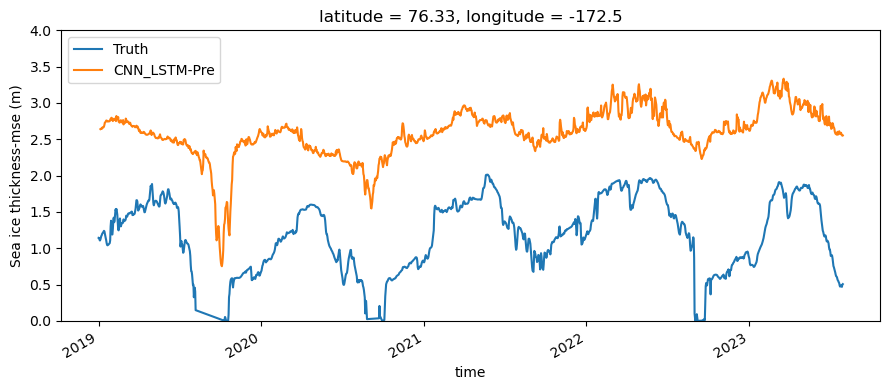

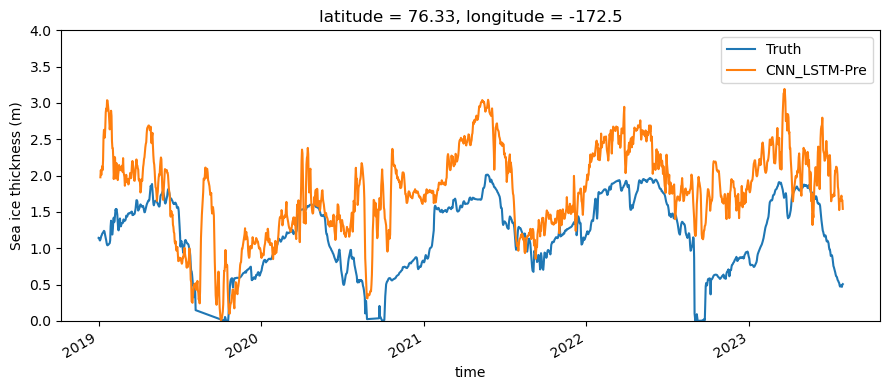

In [86]:
print(y_test_best_pre)
lat = 76.23
lon = -172.46
#best
fig, ax = plt.subplots(figsize=(9, 4))
y_test_xr.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Truth')
y_test_best_pre.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='CNN_LSTM-Pre')
ax.set_ylim(0, 4)
ax.legend()
ax.set_ylabel('Sea ice thickness-mse (m)') 

plt.tight_layout()
plt.show()
#top2
fig, ax = plt.subplots(figsize=(9, 4))
y_test_xr.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Truth')
y_test_top2_pre.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='CNN_LSTM-Pre')

ax.legend()
ax.set_ylabel('Sea ice thickness (m)') 
ax.set_ylim(0, 4)
plt.tight_layout()
plt.show()

In [87]:
meanstd_outputs = {}
outputs = ["sithick"]

def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    normalized_data = (data - mean) / std
    return normalized_data

for var in outputs:  
    meanstd_outputs[var] = (y_test_xr[var].data.mean(), y_test_xr[var].data.std())

for var in outputs:  

    print(f"Working on variable: {var}")
    print("Contents of meanstd_outputs dictionary:", meanstd_outputs)

    # Normalize the pre data
    var_dims = y_test_best_pre.dims
    y_test_best_pre_nor = y_test_best_pre.assign({var: (var_dims, normalize(y_test_best_pre[var].data, var, meanstd_outputs))})
    var_dims = y_test_top2_pre.dims
    y_test_top2_pre_nor = y_test_top2_pre.assign({var: (var_dims, normalize(y_test_top2_pre[var].data, var, meanstd_outputs))})

Working on variable: sithick
Contents of meanstd_outputs dictionary: {'sithick': (1.1953518, 0.5073721)}


In [88]:
from matplotlib.colors import LinearSegmentedColormap as color

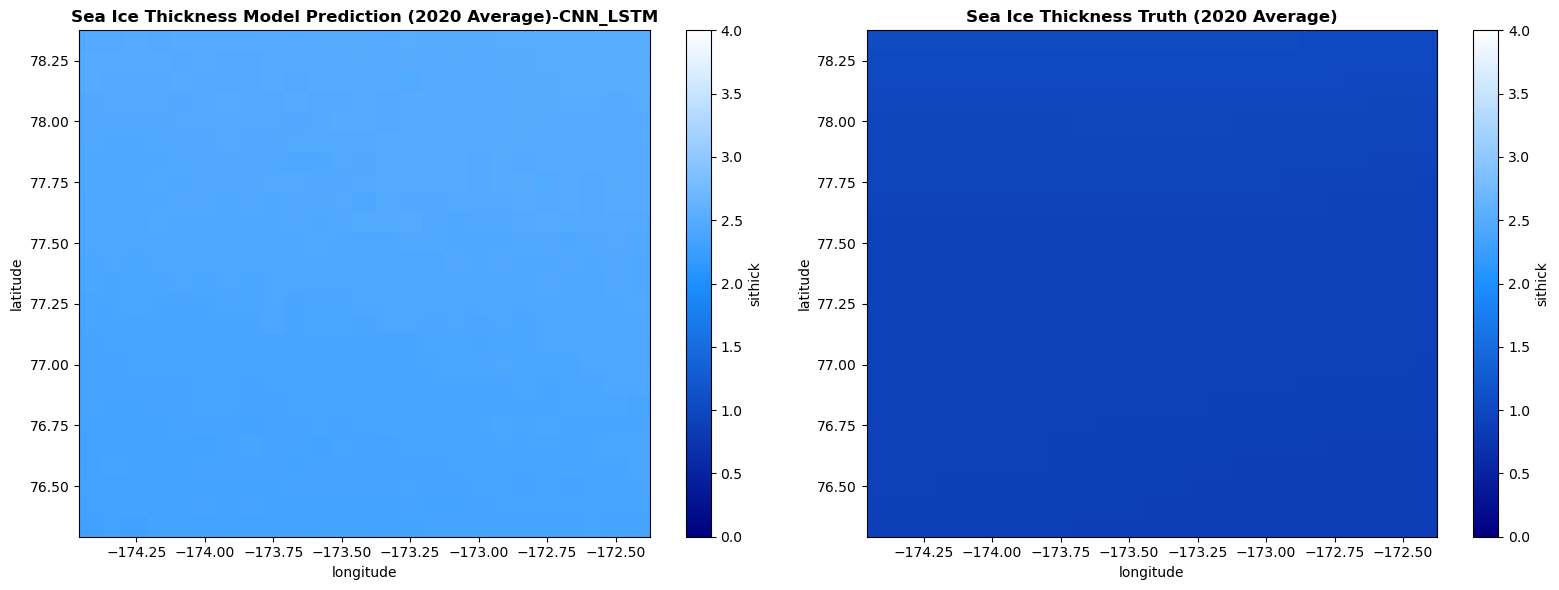

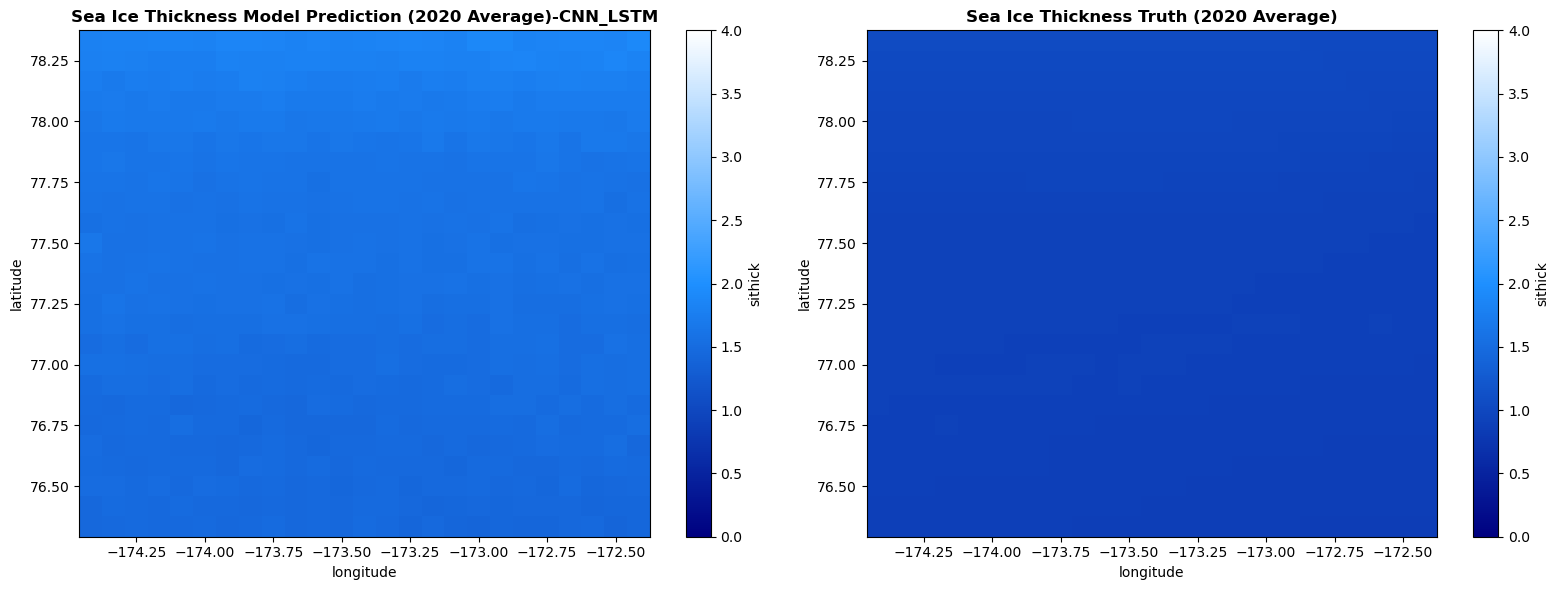

In [89]:
# 2020 average
vmin, vmax = 0, 4
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)


fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

best_2020_mean = y_test_best_pre.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_xr.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

best_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)

axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-CNN_LSTM', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

top2_2020_mean = y_test_top2_pre.sithick.sel(time=slice("2020-01-01", "2020-7-31")).mean(dim='time')
np_2020_mean = y_test_xr.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

top2_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)

axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-CNN_LSTM', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')
plt.tight_layout()
plt.show()

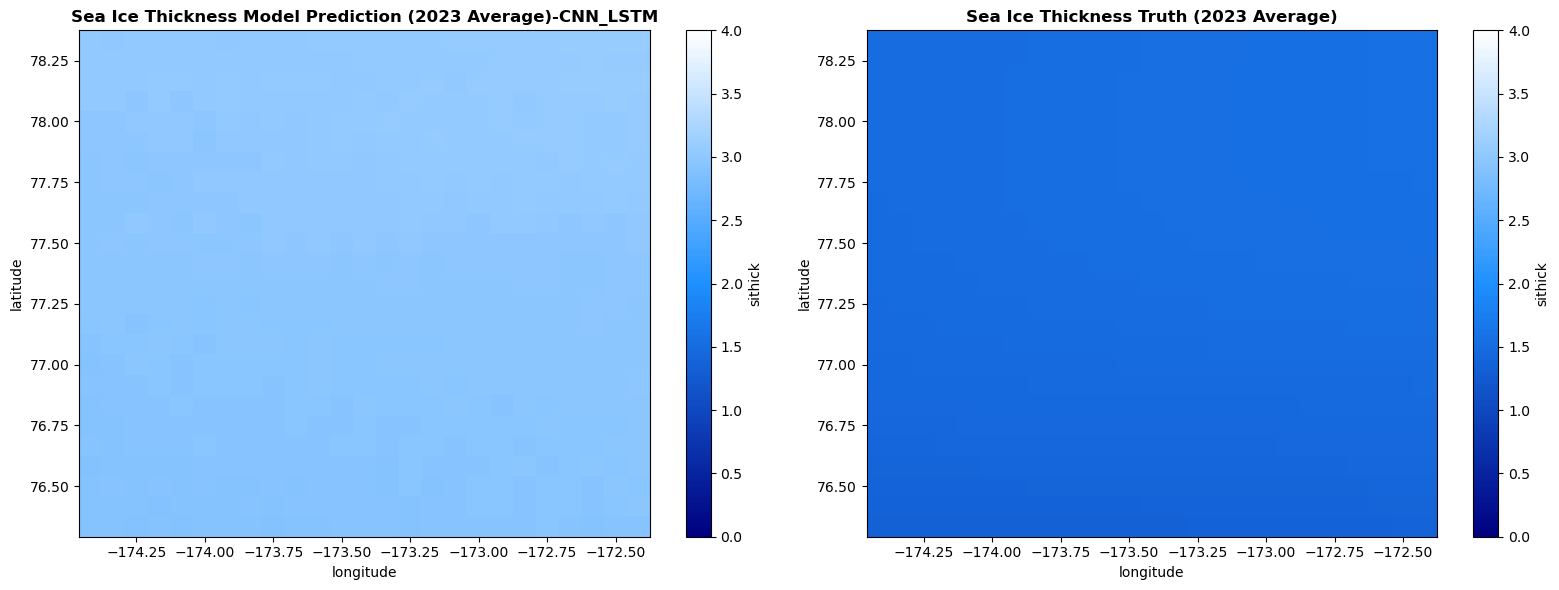

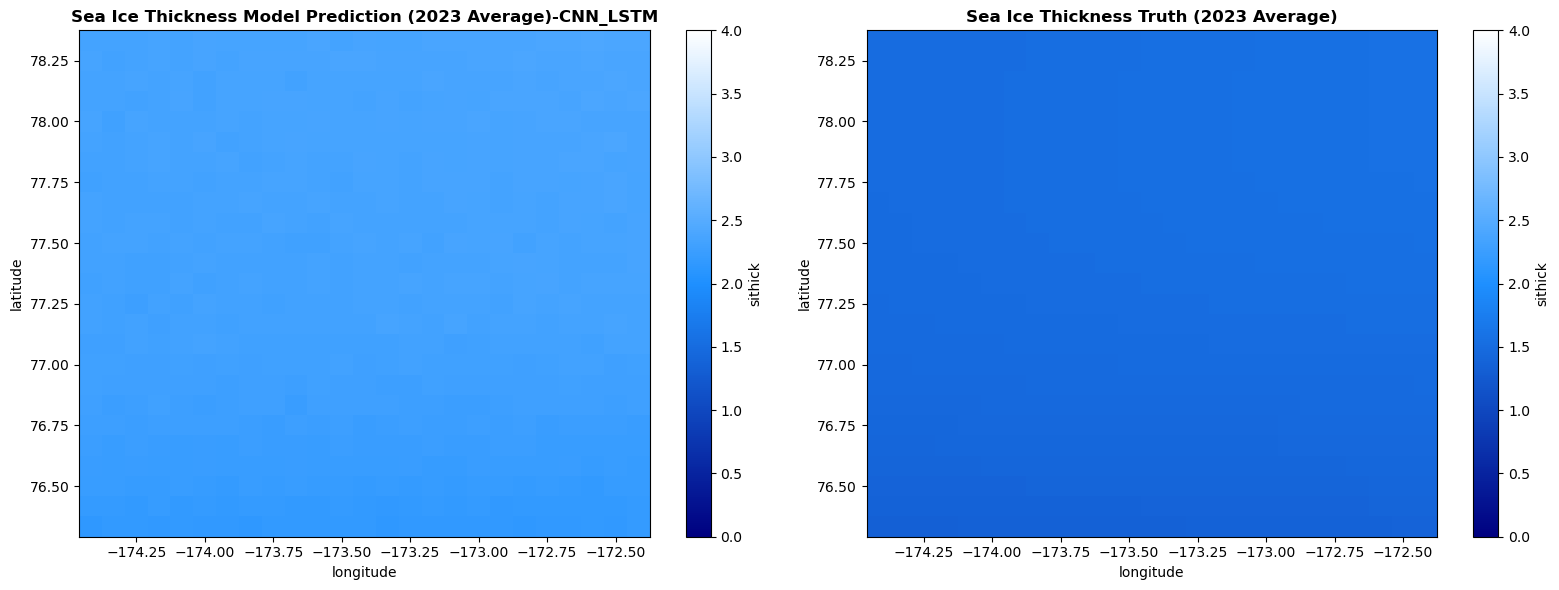

In [90]:
# 2023 average
vmin, vmax = 0, 4
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)


fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

best_2023_mean = y_test_best_pre.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')
np_2023_mean = y_test_xr.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')

best_2023_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2023_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)

axes[0].set_title('Sea Ice Thickness Model Prediction (2023 Average)-CNN_LSTM', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2023 Average)', fontweight='bold')

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

top2_2023_mean = y_test_top2_pre.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')
np_2023_mean = y_test_xr.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')

top2_2023_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2023_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)

axes[0].set_title('Sea Ice Thickness Model Prediction (2023 Average)-CNN_LSTM', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2023 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

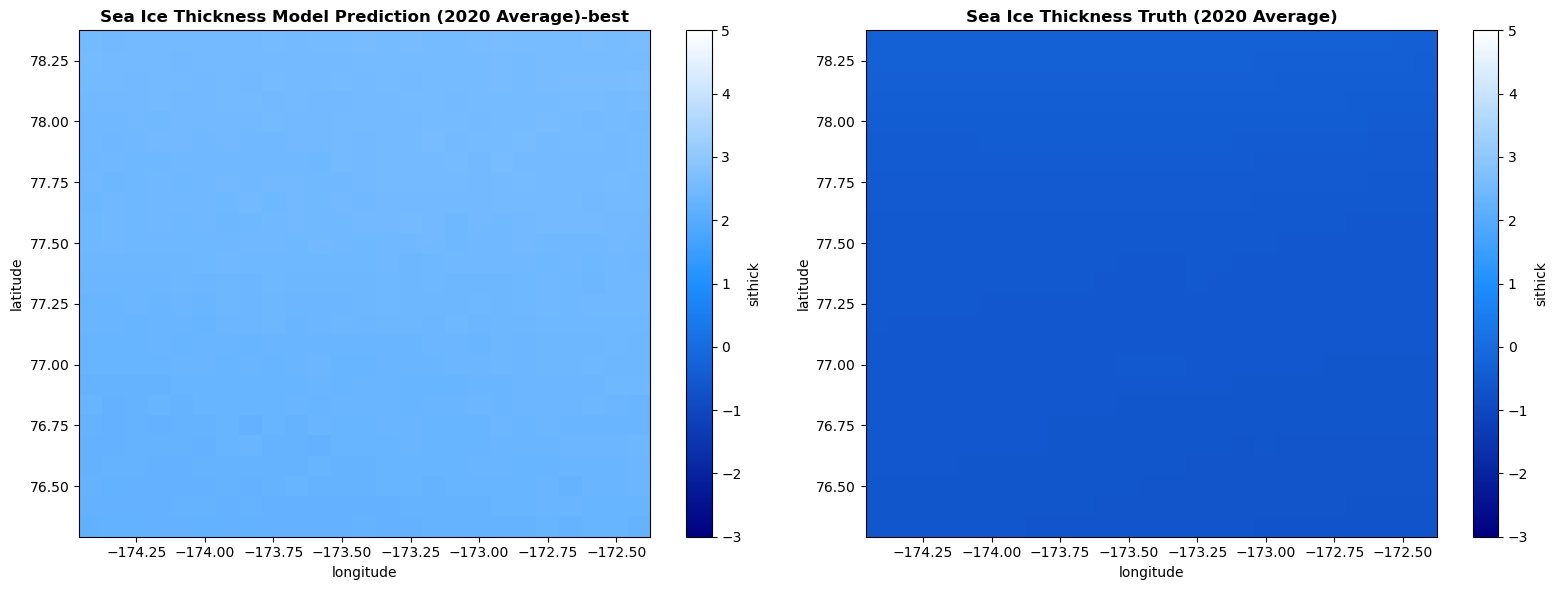

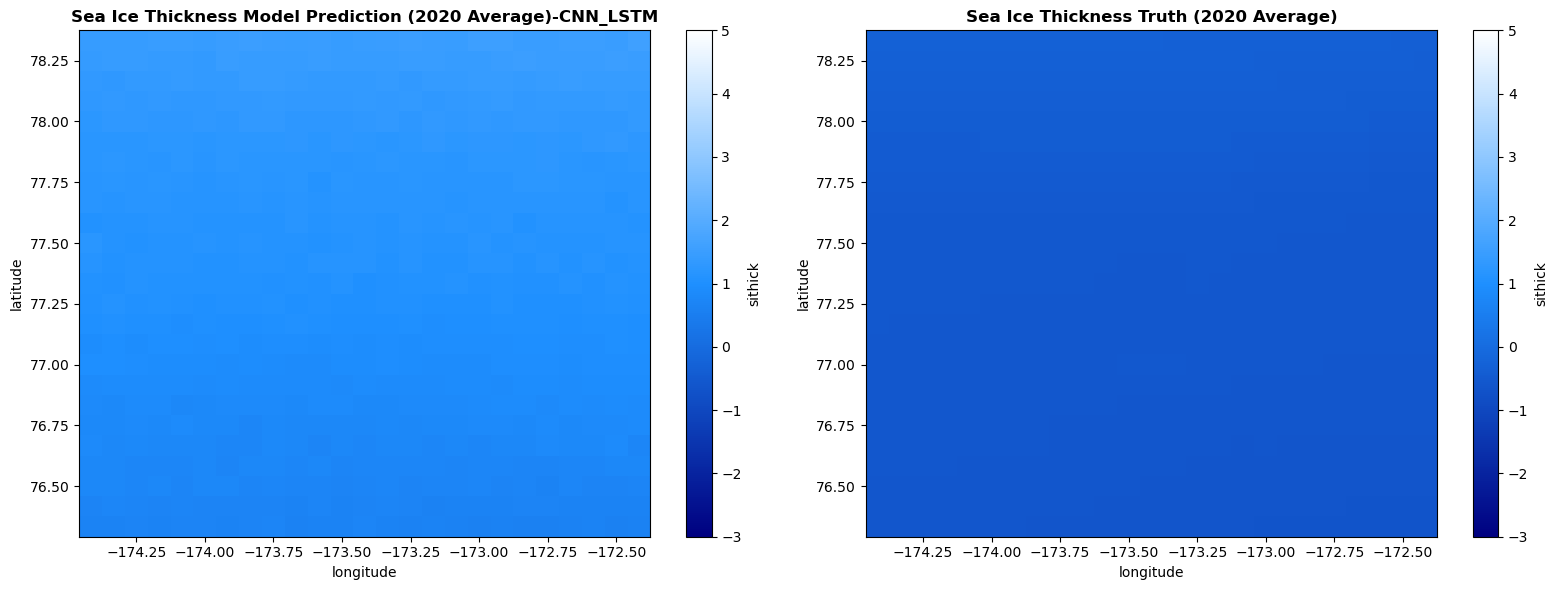

In [91]:
# with normalization 2020 average

vmin, vmax = -3, 5
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)

# best
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

best_2020_mean = y_test_best_pre_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_xr_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

best_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-best', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

# top2
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

top2_2020_mean = y_test_top2_pre_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_xr_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

top2_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-CNN_LSTM', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

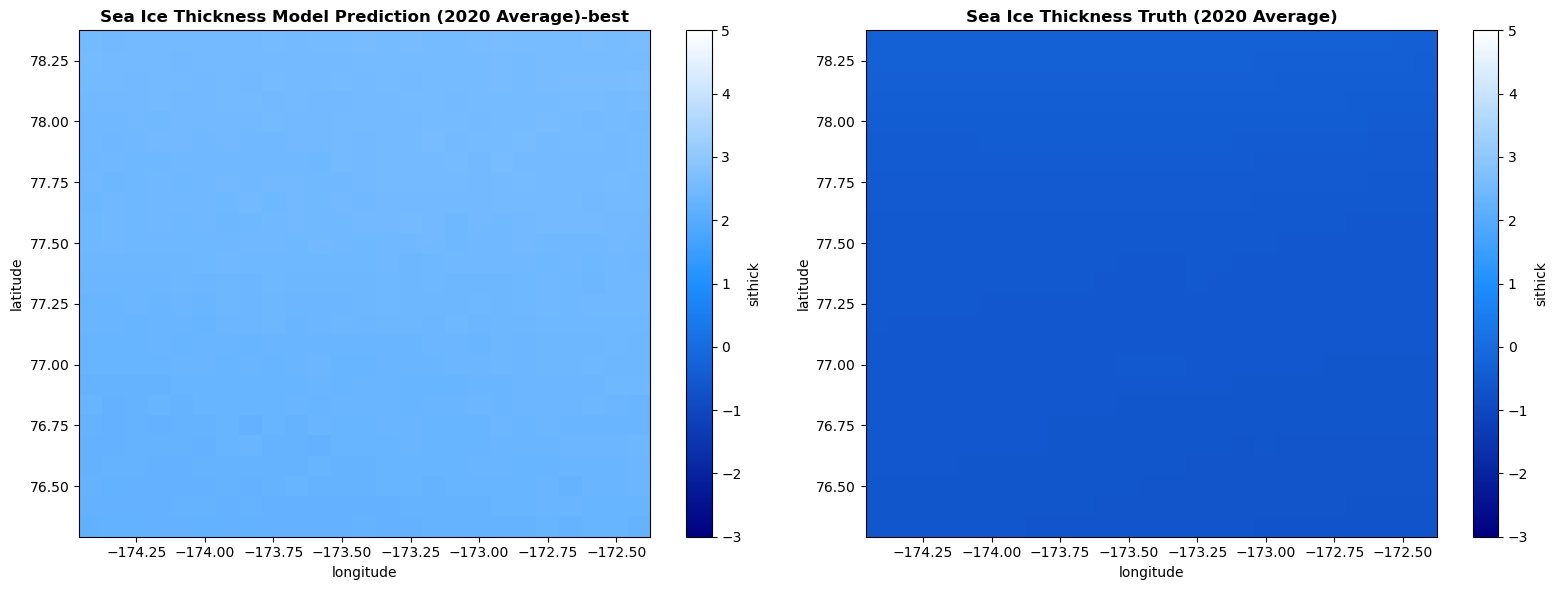

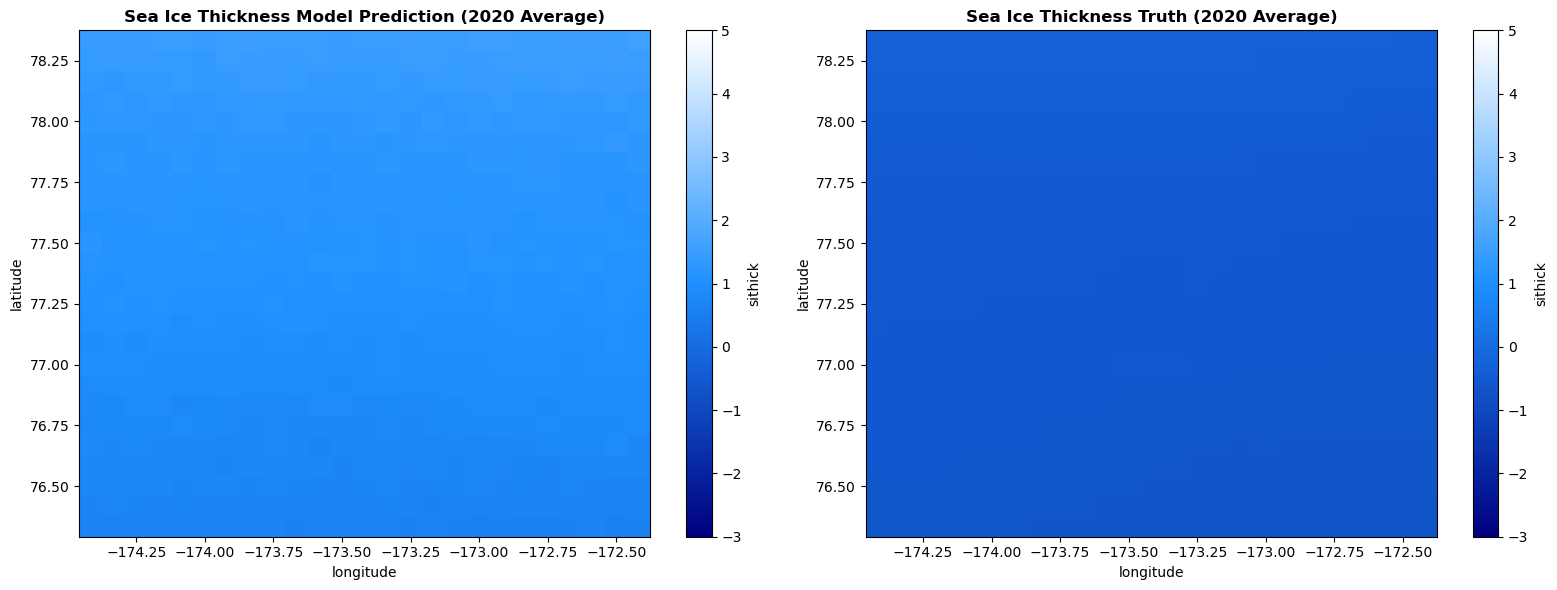

In [92]:
# with normalization 2020 average

vmin, vmax = -3, 5
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)

# best
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

best_2020_mean = y_test_best_pre_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_xr_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

best_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-best', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

# top2
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

top2_2020_mean = y_test_top2_pre_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_xr_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

top2_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

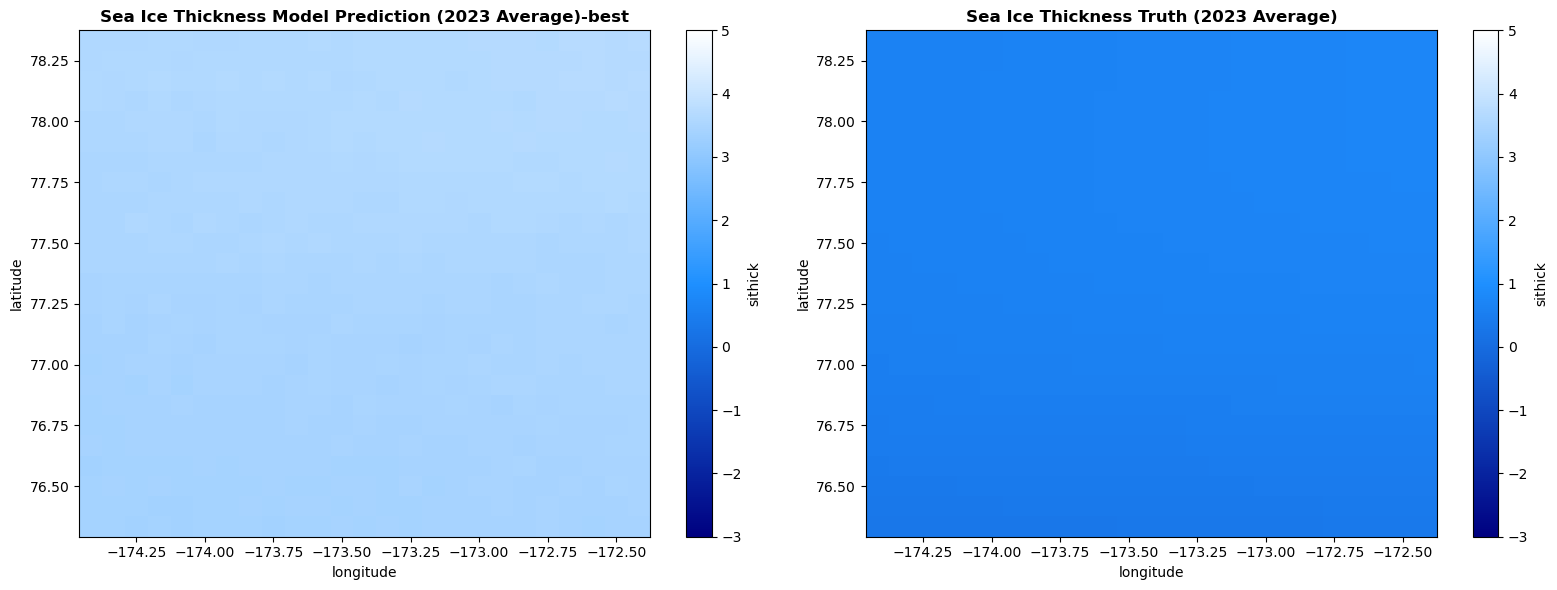

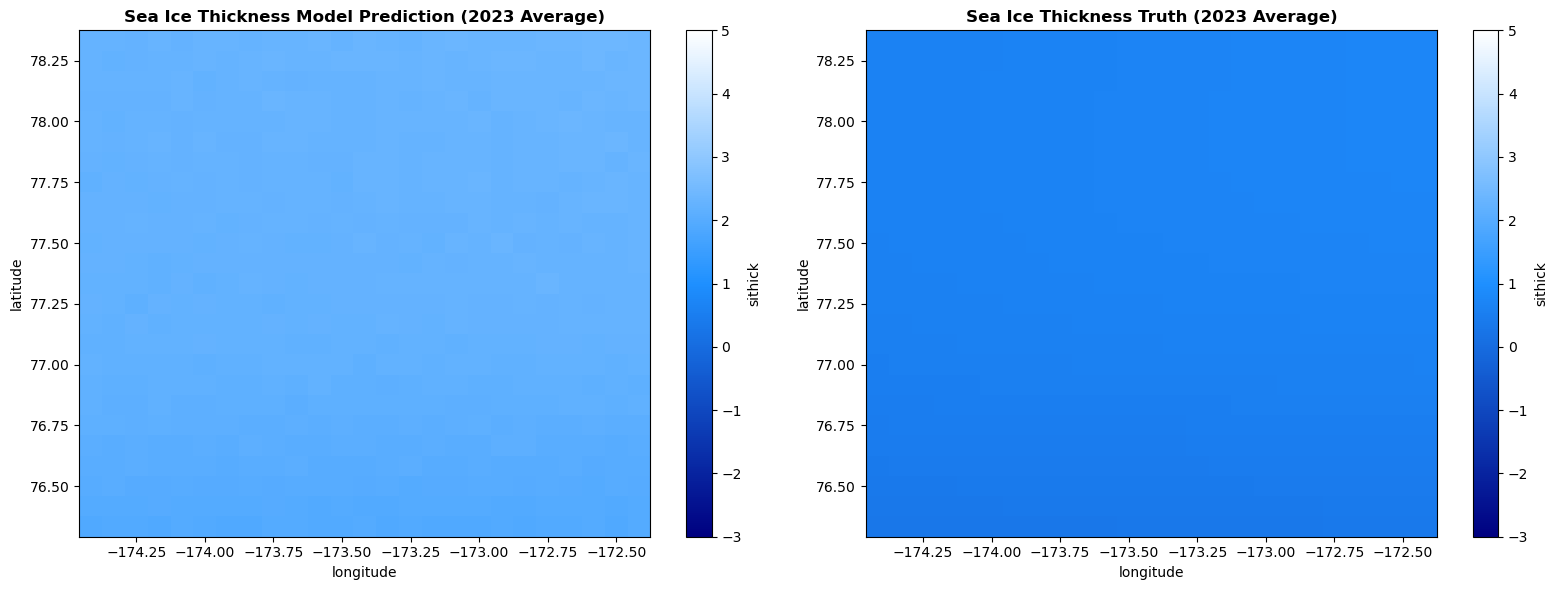

In [93]:
# with normalization 2023 average

vmin, vmax = -3, 5
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)

# best
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

best_2023_mean = y_test_best_pre_nor.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')
np_2023_mean = y_test_xr_nor.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')

best_2023_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2023_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2023 Average)-best', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2023 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

# top2
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

top2_2023_mean = y_test_top2_pre_nor.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')
np_2023_mean = y_test_xr_nor.sithick.sel(time=slice("2023-01-01", "2023-07-31")).mean(dim='time')

top2_2023_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2023_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2023 Average)', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2023 Average)', fontweight='bold')

plt.tight_layout()
plt.show()